### Importing Libraries 

In [9]:
import model_build_marineheatwaves as mhw_mb
import exploratory_data_analysis_mhw_script as eda
import numpy as np

#### Default Parameters Defining

In [10]:
n_lag = 7
n_features = 2
n_seq = 7
epochs = 200
batch_size = 128

### Bay of Bengal Region

##### Model Training 

(10944, 7, 2)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17152     
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                                 
Total params: 17,607
Trainable params: 17,607
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
86/86 [==============================] - 4s 15ms/step - loss: 0.1360 - val_loss: 0.0458
Epoch 2/200
86/86 [==============================] - 1s 8ms/step - loss: 0.0489 - val_loss: 0.0405
Epoch 3/200
86/86 [==============================] - 1s 8ms/step - loss: 0.0470 - val_loss: 0.0397
Epoch 4/200
86/86 [==============================] - 1s 7ms/step - loss: 0.0463 - val_loss: 0.0390
Epoch 5/200
86/86 [================

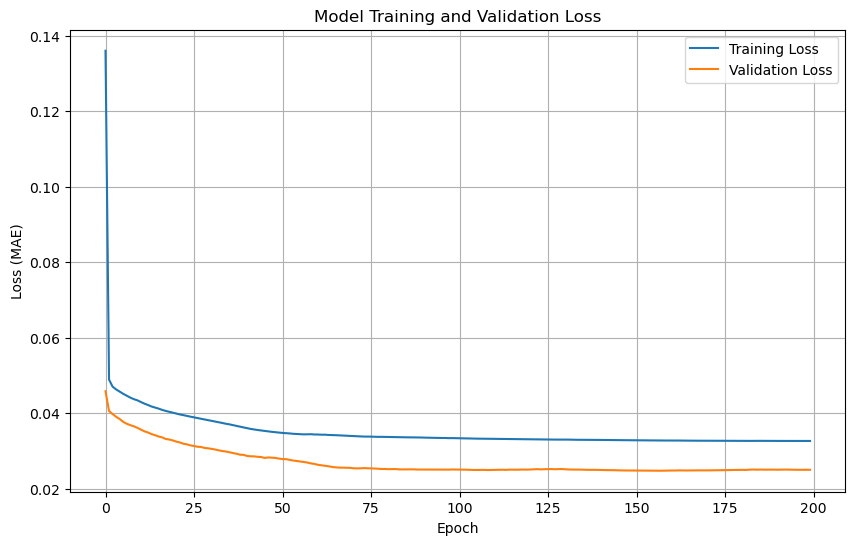

In [11]:
file_path = "Data_sst_2020/bay_of_bengal.nc"
dataset = mhw_mb.load_data(file_path)

# Data splitting 
(train_sst, train_month, train_time), (valid_sst, valid_month, valid_time), (test_sst, test_month, test_time) = mhw_mb.prepare_data_for_modeling(dataset)

# Scale and convert to supervised format
X_train, y_train, X_valid, y_valid, X_test, y_test, sst_min, sst_max = mhw_mb.scale_and_create_sequences(
    train_sst, train_month, valid_sst, valid_month, test_sst, test_month, n_lag, n_seq
)
print(X_train.shape)

model = mhw_mb.build_lstm_model(n_lag, n_features, n_seq)
model.summary()

# Fit Model
history = mhw_mb.fit_lstm_model(model, X_train, y_train, X_valid, y_valid, epochs=epochs, batch_size=batch_size)

mhw_mb.plot_training_history(history)


##### Model Testing and Evaluation

46/46 [==============================] - 1s 3ms/step


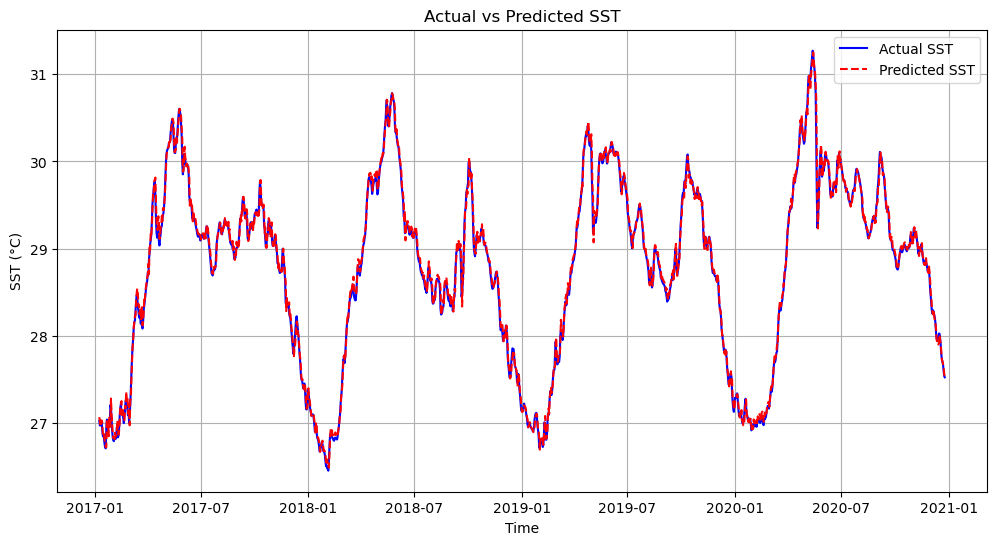

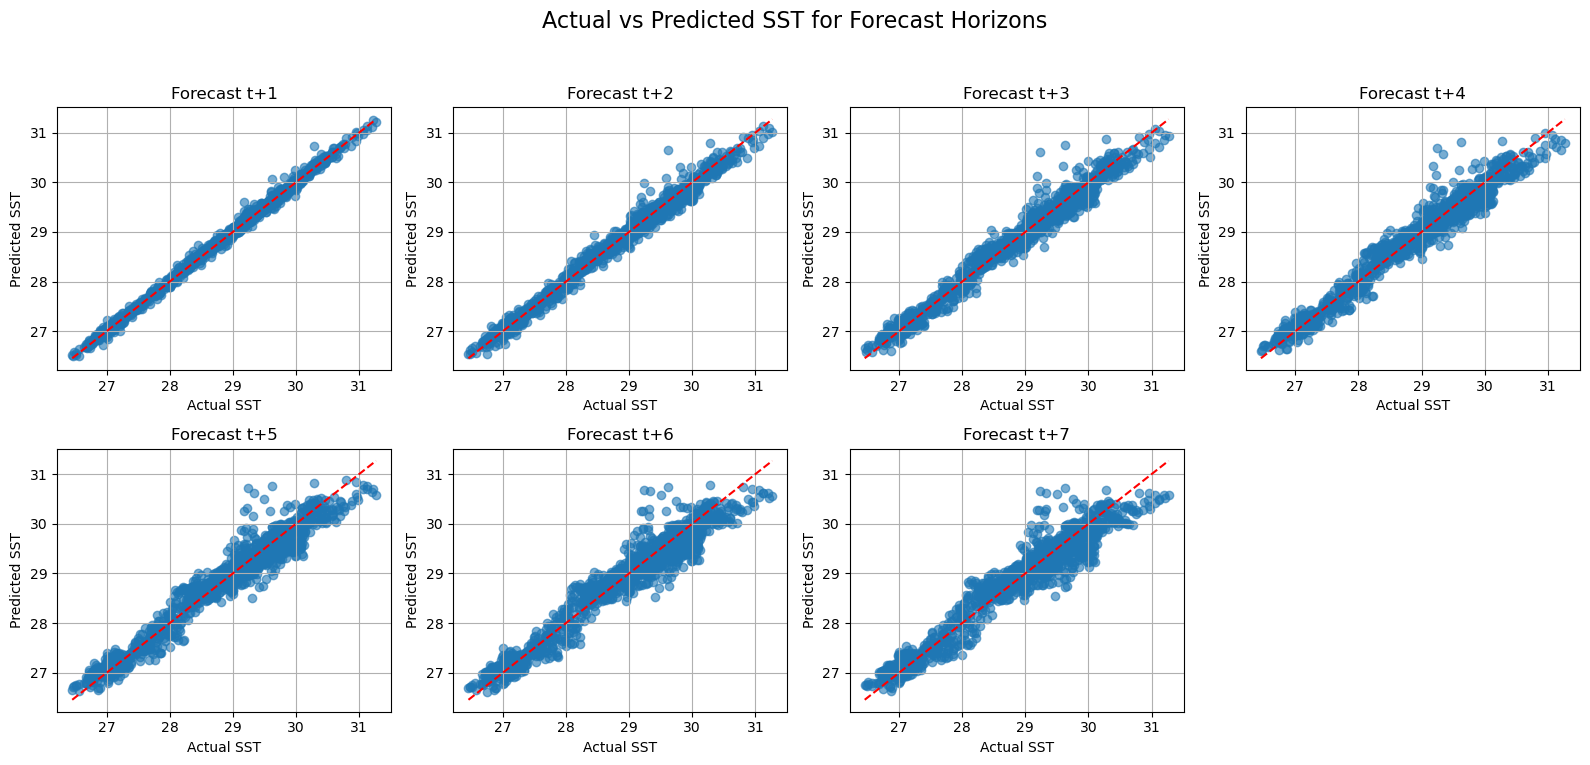

Forecast horizon t+1: RMSE = 0.0657, MAE = 0.0478, R2 = 0.9961
Forecast horizon t+2: RMSE = 0.1212, MAE = 0.0886, R2 = 0.9867
Forecast horizon t+3: RMSE = 0.1676, MAE = 0.1240, R2 = 0.9745
Forecast horizon t+4: RMSE = 0.2026, MAE = 0.1506, R2 = 0.9627
Forecast horizon t+5: RMSE = 0.2314, MAE = 0.1731, R2 = 0.9513
Forecast horizon t+6: RMSE = 0.2568, MAE = 0.1934, R2 = 0.9400
Forecast horizon t+7: RMSE = 0.2753, MAE = 0.2086, R2 = 0.9309


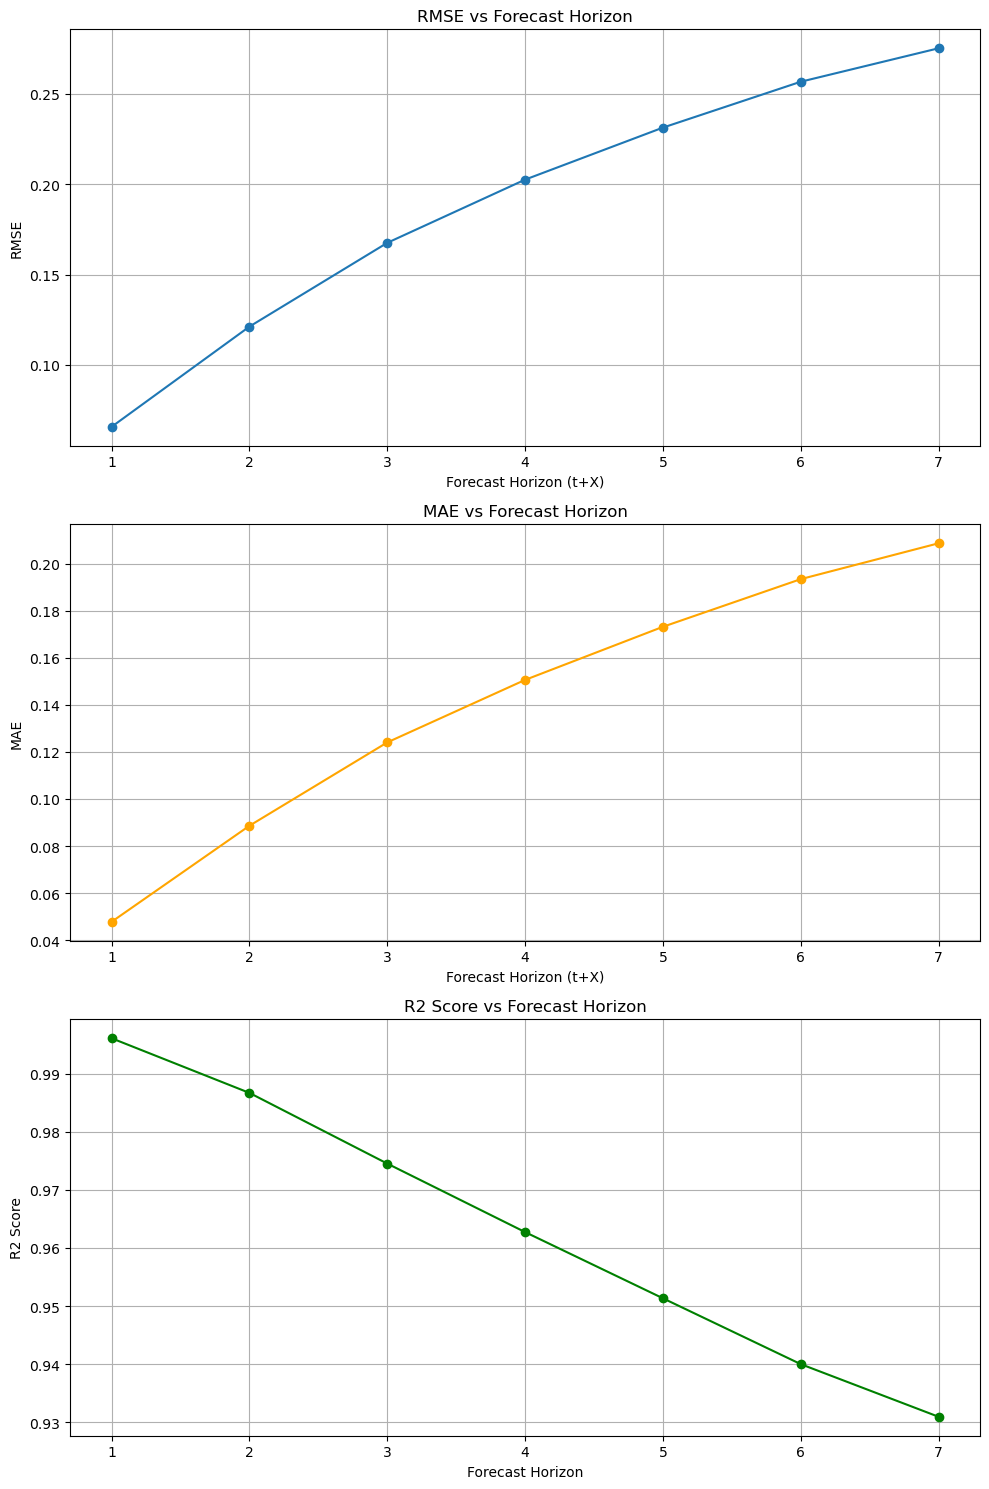

In [12]:
# Forecast and invert scaling
yhat_test_inverted, y_test_inverted = mhw_mb.forecast_and_invert(model, X_test, y_test, sst_min, sst_max)

# Extract predictions
actual_t1_test = y_test_inverted[:, 0]
predicted_t1_test = yhat_test_inverted[:, 0]
adjusted_test_time = test_time[n_lag : - (n_seq - 1)]

# Plot actual vs predicted forecast on the test set
mhw_mb.plot_actual_vs_predicted(
    adjusted_test_time, 
    actual_t1_test, 
    predicted_t1_test, 
    title="Actual vs Predicted SST"
)

mhw_mb.plot_sst_scatter_forecasts(y_test_inverted, yhat_test_inverted)
metrics_df_test = mhw_mb.plot_evaluation_metrics_all(y_test_inverted, yhat_test_inverted)
metrics_df_bay = metrics_df_test.copy()

#### MHW Prediciton Evaluation

In [13]:
train_ds_1, train_sst_1, train_t_1 = eda.load_and_prepare_data(file_path)
test_ds_1, test_sst_1, test_t_1 = eda.prepare_testing_dataset(file_path)

##### Plot for t+1 MHW predicted

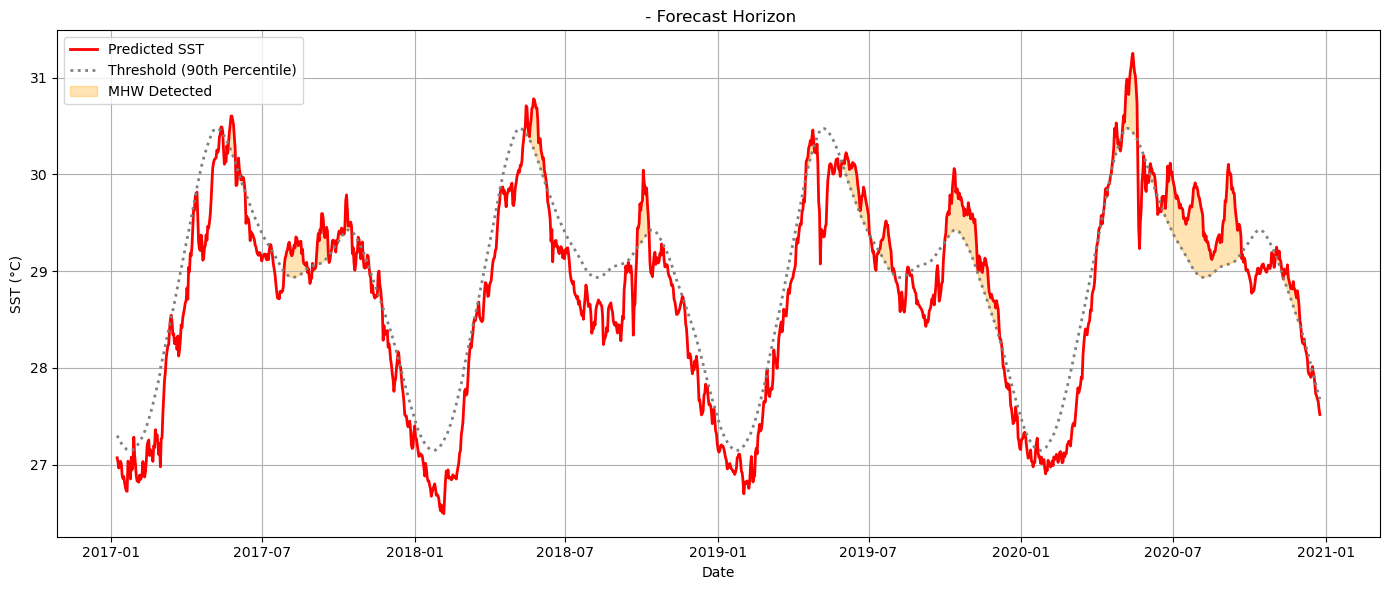

In [14]:
_, clim_pred = eda.detect_mhw_using_training_climatology(
    np.array([d.toordinal() for d in adjusted_test_time]),
    predicted_t1_test,
    train_t_1,
    train_sst_1
)

mhw_mb.plot_predicted_vs_climatology(
    time_array=adjusted_test_time,
    predicted_sst=predicted_t1_test,
    clim_ds=clim_pred,
)


Confusion Matrix for forecast horizon t+1:
[[1015   19]
 [  10  404]]


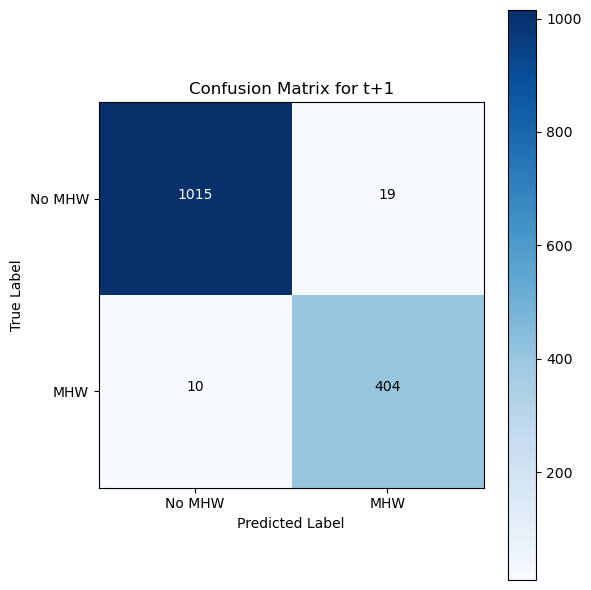

Confusion Matrix for forecast horizon t+2:
[[1018   16]
 [  65  349]]


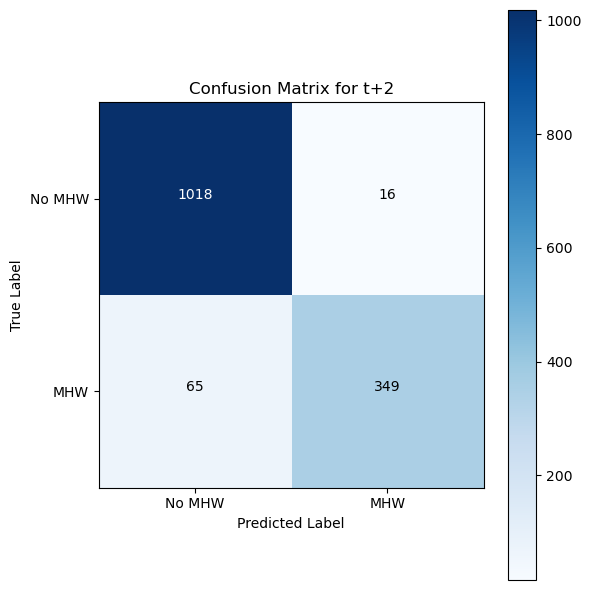

Confusion Matrix for forecast horizon t+3:
[[1000   34]
 [  70  344]]


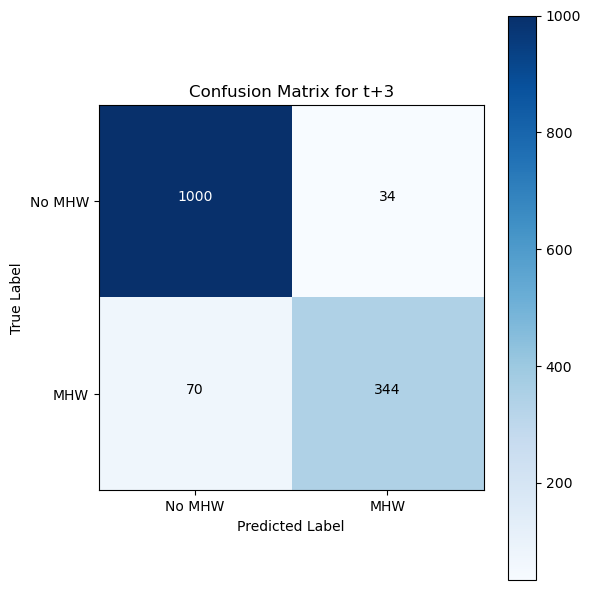

Confusion Matrix for forecast horizon t+4:
[[985  49]
 [ 90 324]]


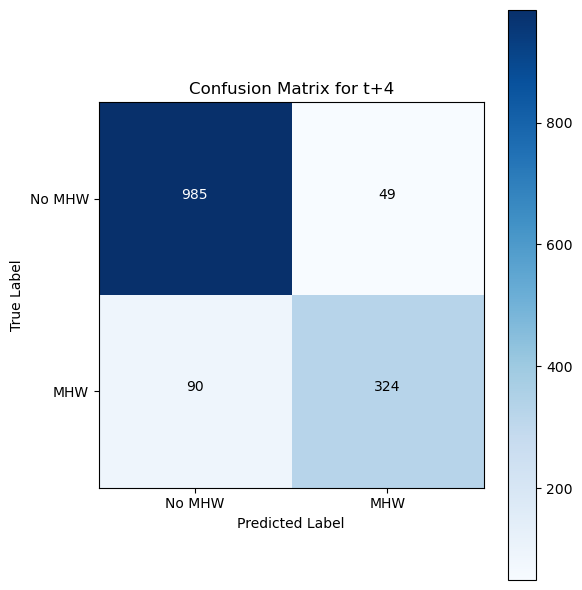

Confusion Matrix for forecast horizon t+5:
[[977  57]
 [118 296]]


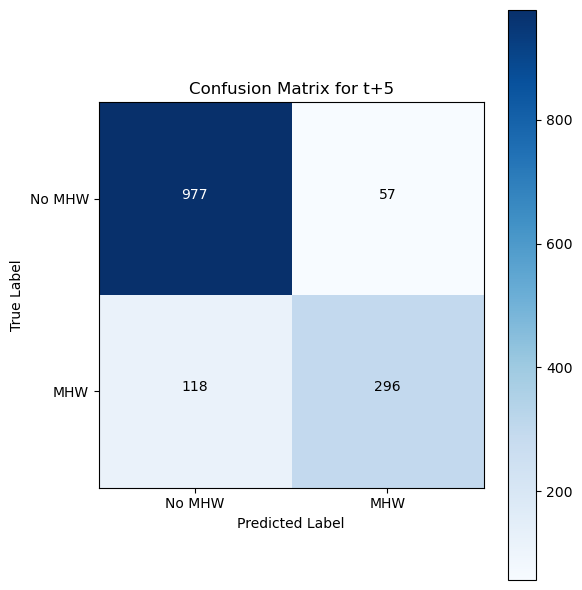

Confusion Matrix for forecast horizon t+6:
[[970  64]
 [138 276]]


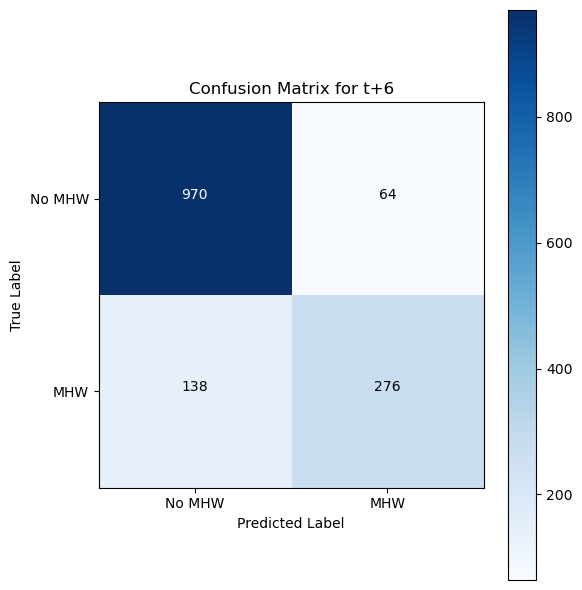

Confusion Matrix for forecast horizon t+7:
[[958  76]
 [147 267]]


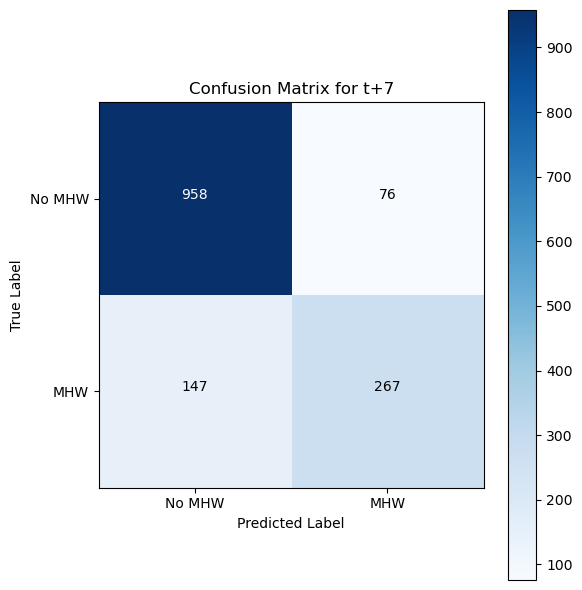

Precision  Recall (TPR)  F1 Score  Accuracy       FPR       TPR  \
Horizon                                                                    
t+1       0.955083      0.975845  0.965352  0.979972  0.018375  0.975845   
t+2       0.956164      0.842995  0.896021  0.944061  0.015474  0.842995   
t+3       0.910053      0.830918  0.868687  0.928177  0.032882  0.830918   
t+4       0.868633      0.782609  0.823380  0.904006  0.047389  0.782609   
t+5       0.838527      0.714976  0.771838  0.879144  0.055126  0.714976   
t+6       0.811765      0.666667  0.732095  0.860497  0.061896  0.666667   
t+7       0.778426      0.644928  0.705416  0.845994  0.073501  0.644928   

              FNR       FDR  
Horizon                      
t+1      0.024155  0.044917  
t+2      0.157005  0.043836  
t+3      0.169082  0.089947  
t+4      0.217391  0.131367  
t+5      0.285024  0.161473  
t+6      0.333333  0.188235  
t+7      0.355072  0.221574

In [15]:
metrics_all = mhw_mb.evaluate_mhw_forecast_horizons(
    adjusted_test_time, y_test_inverted, yhat_test_inverted, train_t_1, train_sst_1, eda
)

df_metrics = mhw_mb.metrics_to_dataframe(metrics_all)
metrics_df_bay_mhw = df_metrics.copy()
df_metrics


### Gulf of Mannar

##### Model Training 

(10944, 7, 2)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                17152     
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                                 
Total params: 17,607
Trainable params: 17,607
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
86/86 [==============================] - 4s 18ms/step - loss: 0.1604 - val_loss: 0.0574
Epoch 2/200
86/86 [==============================] - 1s 9ms/step - loss: 0.0679 - val_loss: 0.0549
Epoch 3/200
86/86 [==============================] - 1s 10ms/step - loss: 0.0669 - val_loss: 0.0544
Epoch 4/200
86/86 [==============================] - 1s 7ms/step - loss: 0.0662 - val_loss: 0.0536
Epoch 5/200
86/86 [===============

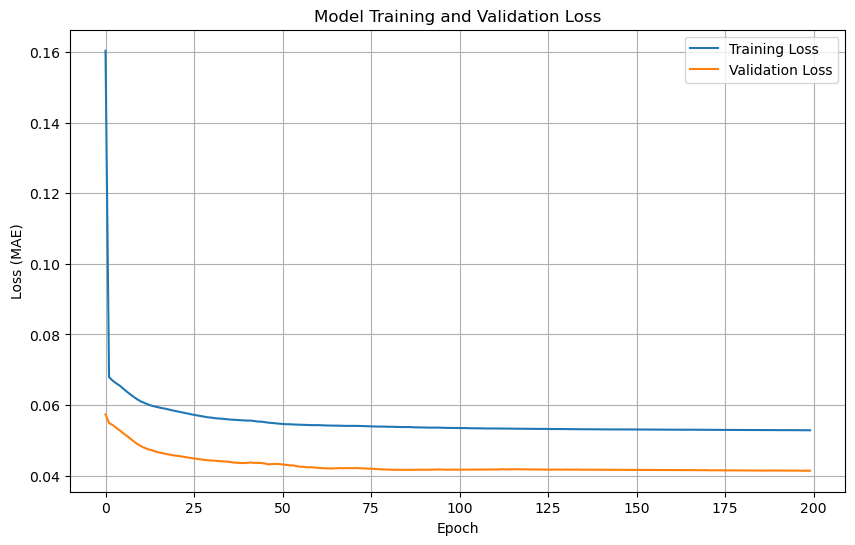

In [17]:
file_path = "Data_sst_2020/gulf_of_mannar.nc"
dataset = mhw_mb.load_data(file_path)

# Data splitting 
(train_sst, train_month, train_time), (valid_sst, valid_month, valid_time), (test_sst, test_month, test_time) = mhw_mb.prepare_data_for_modeling(dataset)

# Scale and convert to supervised format
X_train, y_train, X_valid, y_valid, X_test, y_test, sst_min, sst_max = mhw_mb.scale_and_create_sequences(
    train_sst, train_month, valid_sst, valid_month, test_sst, test_month, n_lag, n_seq
)
print(X_train.shape)

model = mhw_mb.build_lstm_model(n_lag, n_features, n_seq)
model.summary()

# Fit Model
history = mhw_mb.fit_lstm_model(model, X_train, y_train, X_valid, y_valid, epochs=epochs, batch_size=batch_size)

mhw_mb.plot_training_history(history)


##### Model Testing and Evaluation

46/46 [==============================] - 1s 3ms/step


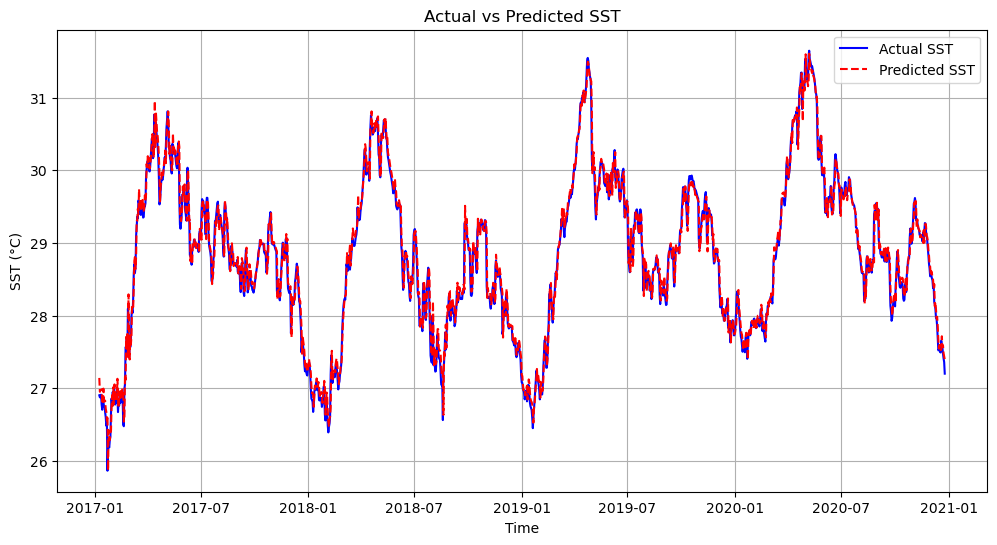

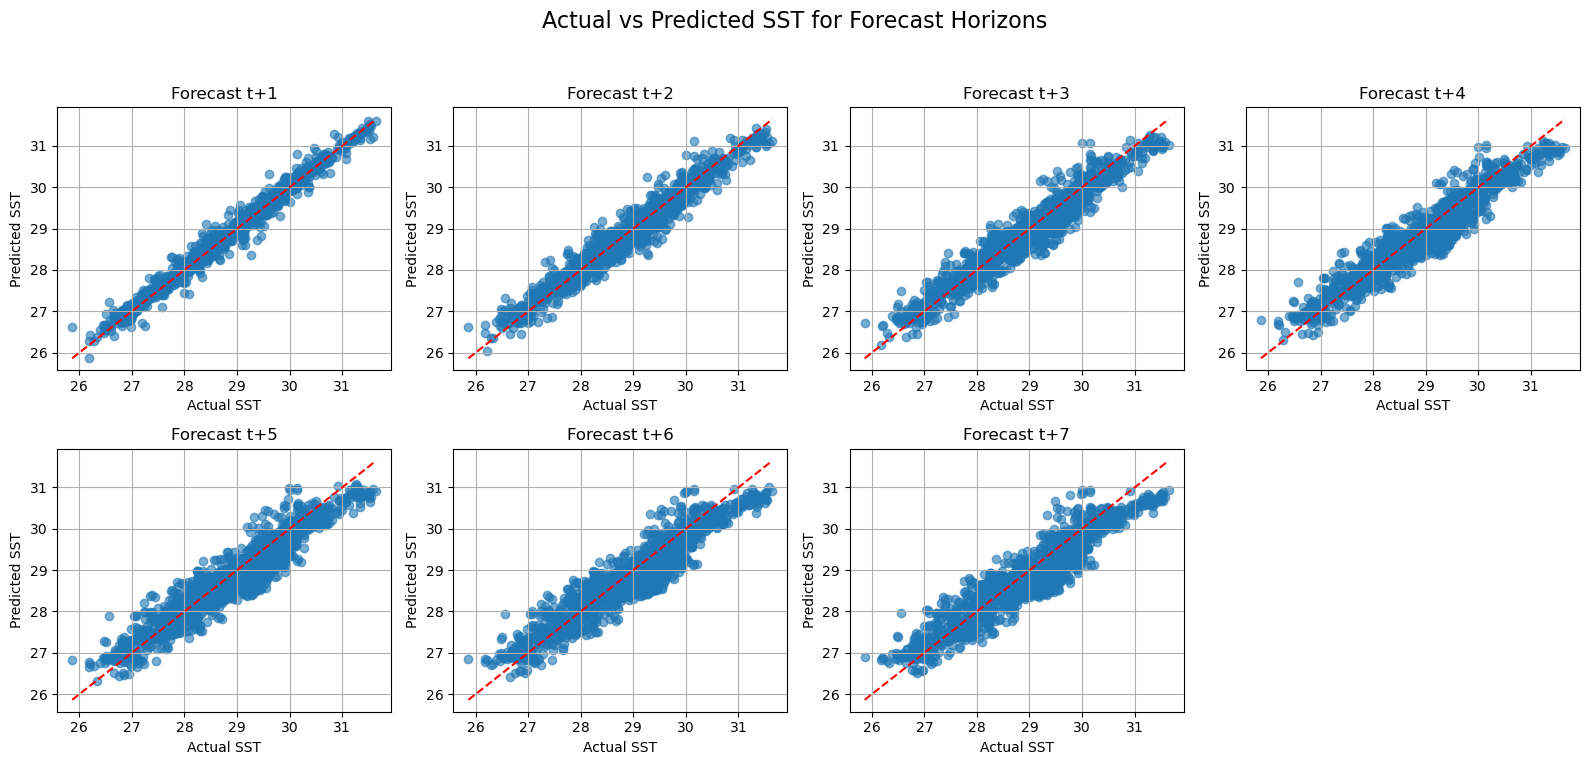

Forecast horizon t+1: RMSE = 0.1528, MAE = 0.1070, R2 = 0.9804
Forecast horizon t+2: RMSE = 0.2358, MAE = 0.1791, R2 = 0.9533
Forecast horizon t+3: RMSE = 0.2925, MAE = 0.2291, R2 = 0.9281
Forecast horizon t+4: RMSE = 0.3360, MAE = 0.2664, R2 = 0.9051
Forecast horizon t+5: RMSE = 0.3637, MAE = 0.2898, R2 = 0.8888
Forecast horizon t+6: RMSE = 0.3869, MAE = 0.3104, R2 = 0.8740
Forecast horizon t+7: RMSE = 0.4040, MAE = 0.3245, R2 = 0.8625


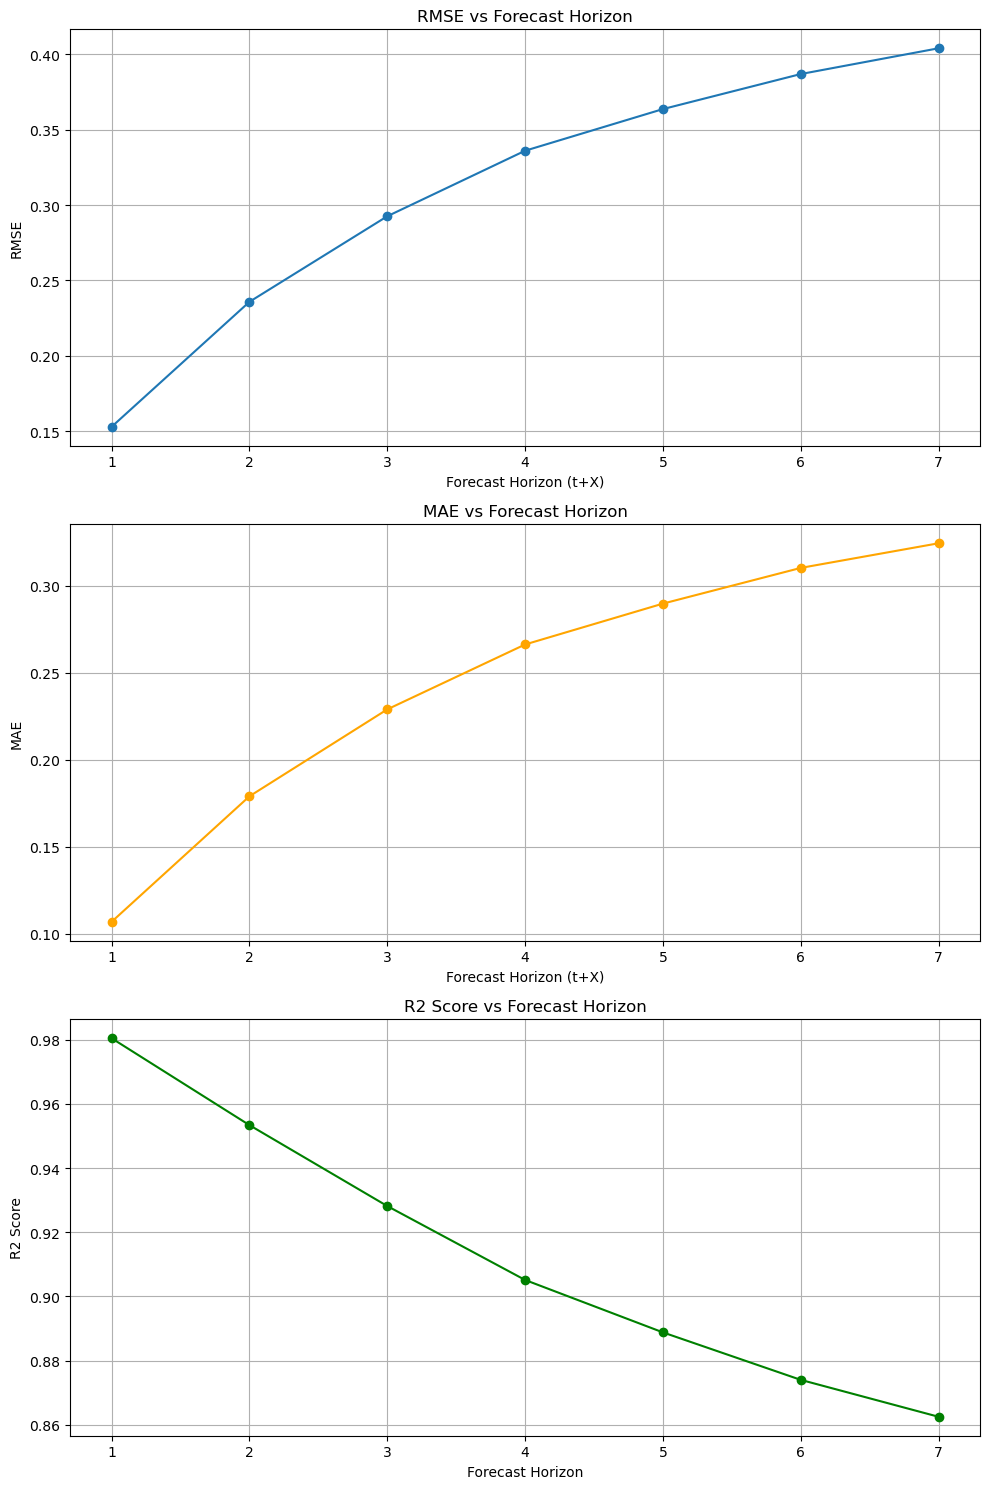

In [18]:
# Forecast and invert scaling
yhat_test_inverted, y_test_inverted = mhw_mb.forecast_and_invert(model, X_test, y_test, sst_min, sst_max)

# Extract predictions t+1 
actual_t1_test = y_test_inverted[:, 0]
predicted_t1_test = yhat_test_inverted[:, 0]
adjusted_test_time = test_time[n_lag : - (n_seq - 1)]

# Plot actual vs predicted for t forecast on the test set
mhw_mb.plot_actual_vs_predicted(
    adjusted_test_time, 
    actual_t1_test, 
    predicted_t1_test, 
    title="Actual vs Predicted SST"
)

mhw_mb.plot_sst_scatter_forecasts(y_test_inverted, yhat_test_inverted)

metrics_df_test = mhw_mb.plot_evaluation_metrics_all(y_test_inverted, yhat_test_inverted)
metrics_df_mannar = metrics_df_test.copy()


#### MHW Prediciton Evaluation

In [19]:
train_ds_1, train_sst_1, train_t_1 = eda.load_and_prepare_data(file_path)
test_ds_1, test_sst_1, test_t_1 = eda.prepare_testing_dataset(file_path)


##### Plot for t+1 MHW predicted

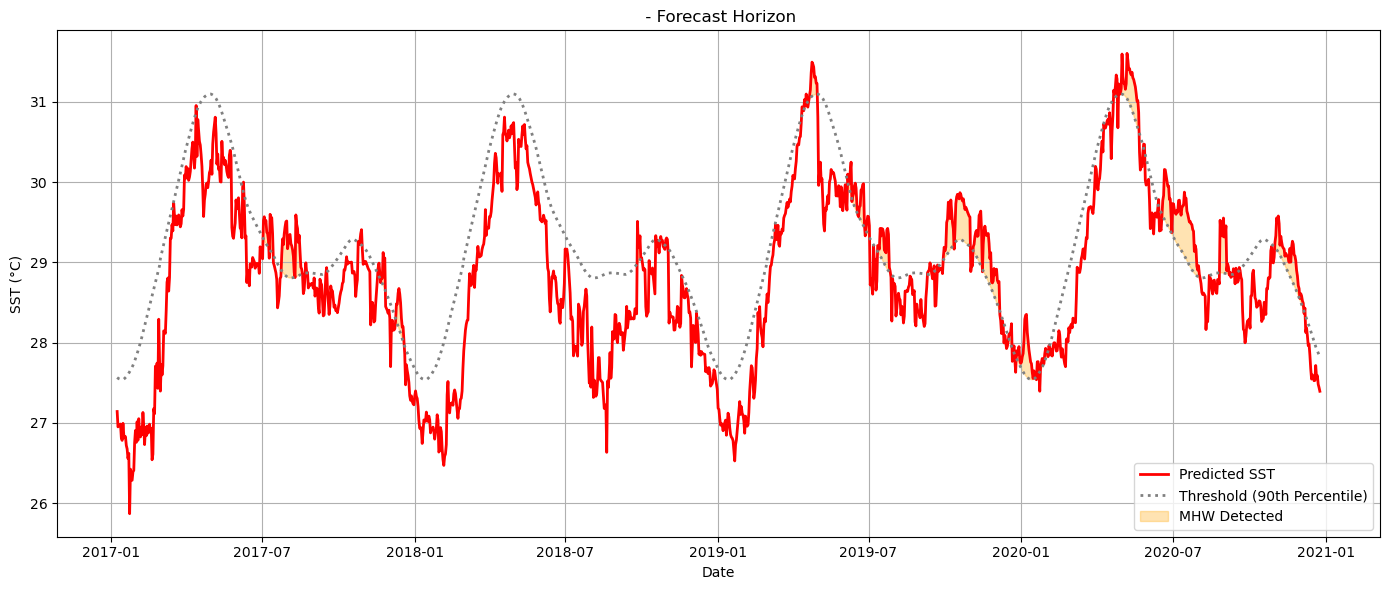

In [20]:
_, clim_pred = eda.detect_mhw_using_training_climatology(
    np.array([d.toordinal() for d in adjusted_test_time]),
    predicted_t1_test,
    train_t_1,
    train_sst_1
)

mhw_mb.plot_predicted_vs_climatology(
    time_array=adjusted_test_time,
    predicted_sst=predicted_t1_test,
    clim_ds=clim_pred,
)


Confusion Matrix for forecast horizon t+1:
[[1092   28]
 [  44  284]]


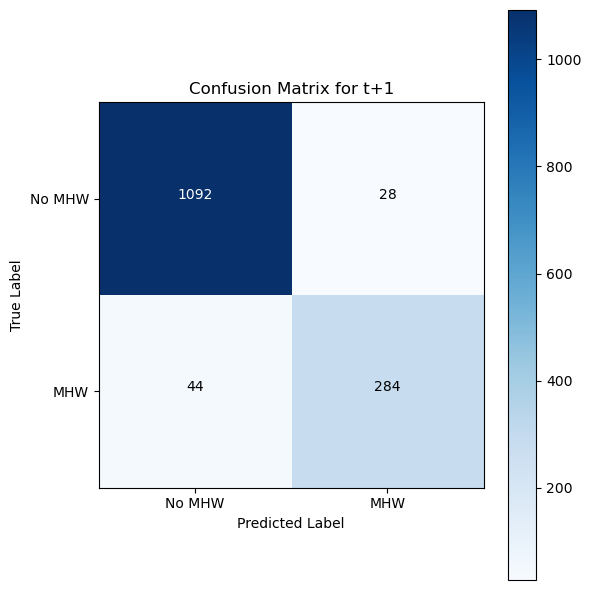

Confusion Matrix for forecast horizon t+2:
[[1086   34]
 [  87  241]]


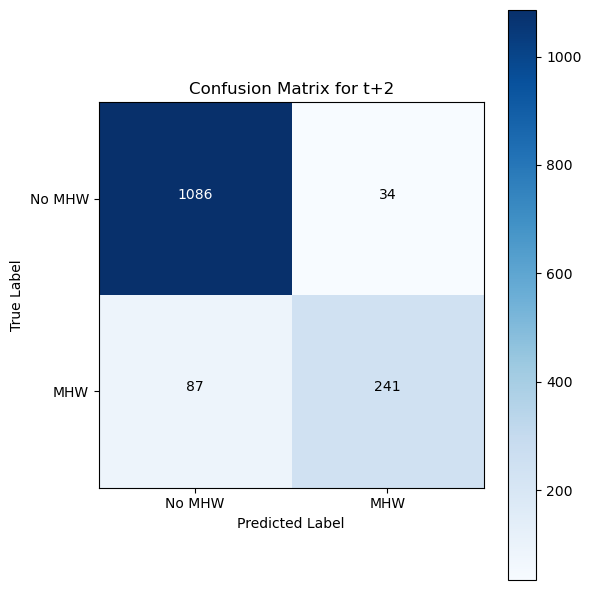

Confusion Matrix for forecast horizon t+3:
[[1089   31]
 [ 136  192]]


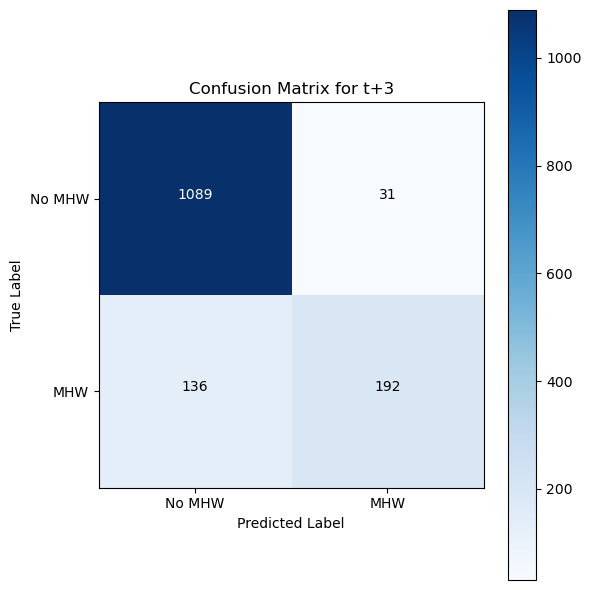

Confusion Matrix for forecast horizon t+4:
[[1084   36]
 [ 189  139]]


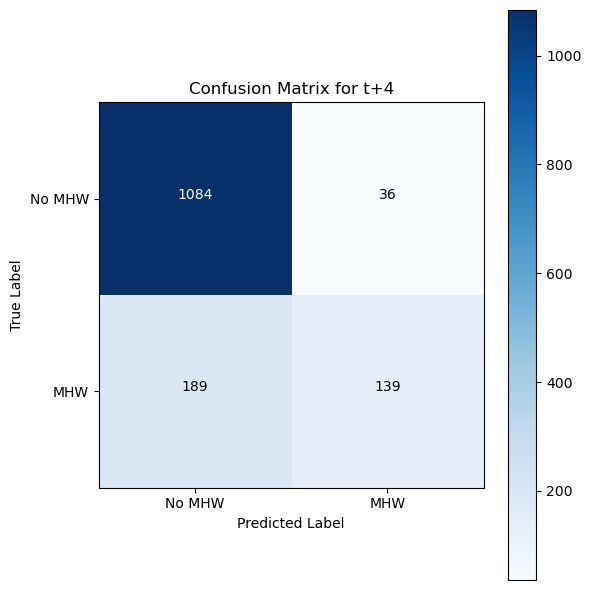

Confusion Matrix for forecast horizon t+5:
[[1083   37]
 [ 213  115]]


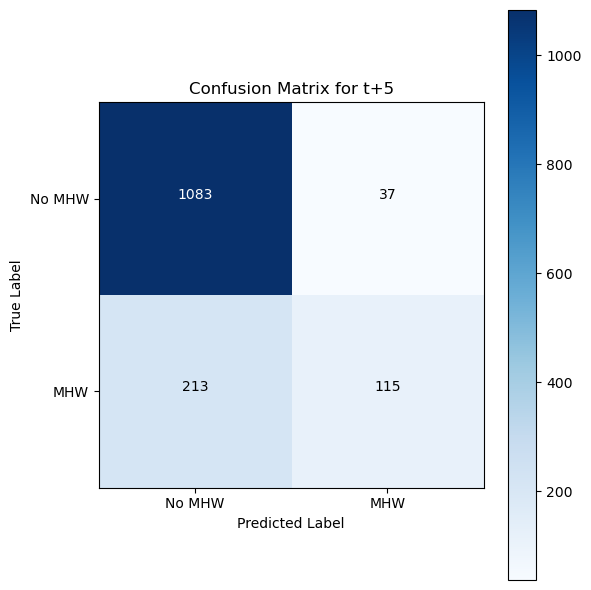

Confusion Matrix for forecast horizon t+6:
[[1081   39]
 [ 231   97]]


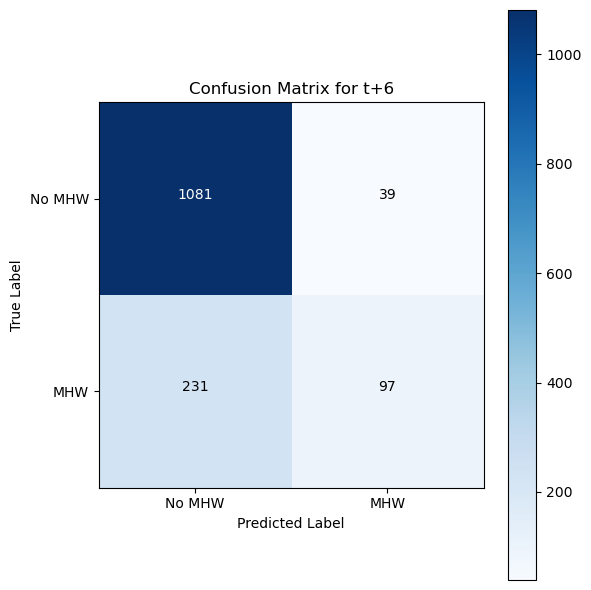

Confusion Matrix for forecast horizon t+7:
[[1078   42]
 [ 241   87]]


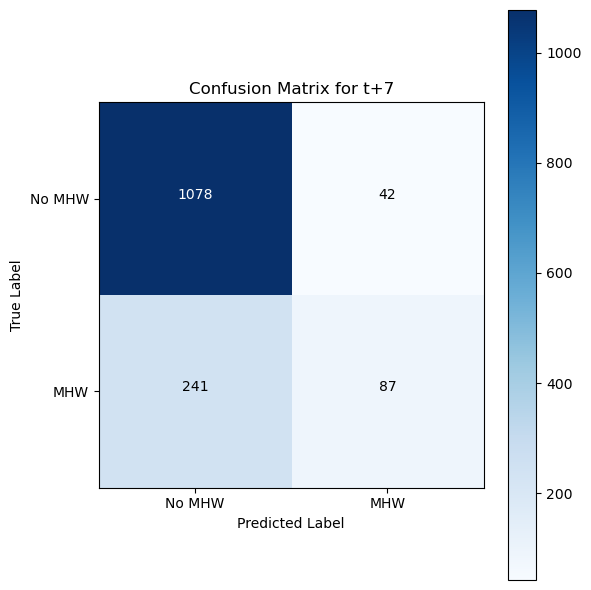

Precision  Recall (TPR)  F1 Score  Accuracy       FPR       TPR  \
Horizon                                                                    
t+1       0.910256      0.865854  0.887500  0.950276  0.025000  0.865854   
t+2       0.876364      0.734756  0.799337  0.916436  0.030357  0.734756   
t+3       0.860987      0.585366  0.696915  0.884669  0.027679  0.585366   
t+4       0.794286      0.423780  0.552684  0.844613  0.032143  0.423780   
t+5       0.756579      0.350610  0.479167  0.827348  0.033036  0.350610   
t+6       0.713235      0.295732  0.418103  0.813536  0.034821  0.295732   
t+7       0.674419      0.265244  0.380744  0.804558  0.037500  0.265244   

              FNR       FDR  
Horizon                      
t+1      0.134146  0.089744  
t+2      0.265244  0.123636  
t+3      0.414634  0.139013  
t+4      0.576220  0.205714  
t+5      0.649390  0.243421  
t+6      0.704268  0.286765  
t+7      0.734756  0.325581

In [21]:
metrics_all = mhw_mb.evaluate_mhw_forecast_horizons(
    adjusted_test_time, y_test_inverted, yhat_test_inverted, train_t_1, train_sst_1, eda
)

df_metrics = mhw_mb.metrics_to_dataframe(metrics_all)
metrics_df_mannar_mhw = df_metrics.copy()
df_metrics

### Laccadive Sea

##### Model Training 

(10944, 7, 2)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                17152     
                                                                 
 dense_3 (Dense)             (None, 7)                 455       
                                                                 
Total params: 17,607
Trainable params: 17,607
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
86/86 [==============================] - 4s 20ms/step - loss: 0.1171 - val_loss: 0.0510
Epoch 2/200
86/86 [==============================] - 1s 10ms/step - loss: 0.0613 - val_loss: 0.0495
Epoch 3/200
86/86 [==============================] - 1s 9ms/step - loss: 0.0602 - val_loss: 0.0476
Epoch 4/200
86/86 [==============================] - 1s 11ms/step - loss: 0.0597 - val_loss: 0.0468
Epoch 5/200
86/86 [==============

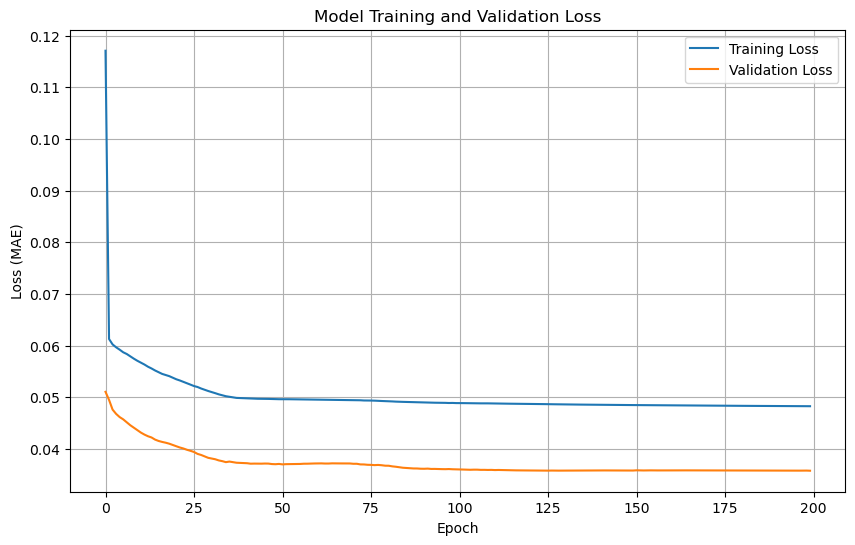

In [22]:
file_path = "Data_sst_2020/laccadive_sea.nc"
dataset = mhw_mb.load_data(file_path)

# Data splitting 
(train_sst, train_month, train_time), (valid_sst, valid_month, valid_time), (test_sst, test_month, test_time) = mhw_mb.prepare_data_for_modeling(dataset)

# Scale and convert to supervised format
X_train, y_train, X_valid, y_valid, X_test, y_test, sst_min, sst_max = mhw_mb.scale_and_create_sequences(
    train_sst, train_month, valid_sst, valid_month, test_sst, test_month, n_lag, n_seq
)
print(X_train.shape)

model = mhw_mb.build_lstm_model(n_lag, n_features, n_seq)

model.summary()

# Fit Model
history = mhw_mb.fit_lstm_model(model, X_train, y_train, X_valid, y_valid, epochs=epochs, batch_size=batch_size)

mhw_mb.plot_training_history(history)


##### Model Testing and Evaluation

46/46 [==============================] - 0s 3ms/step


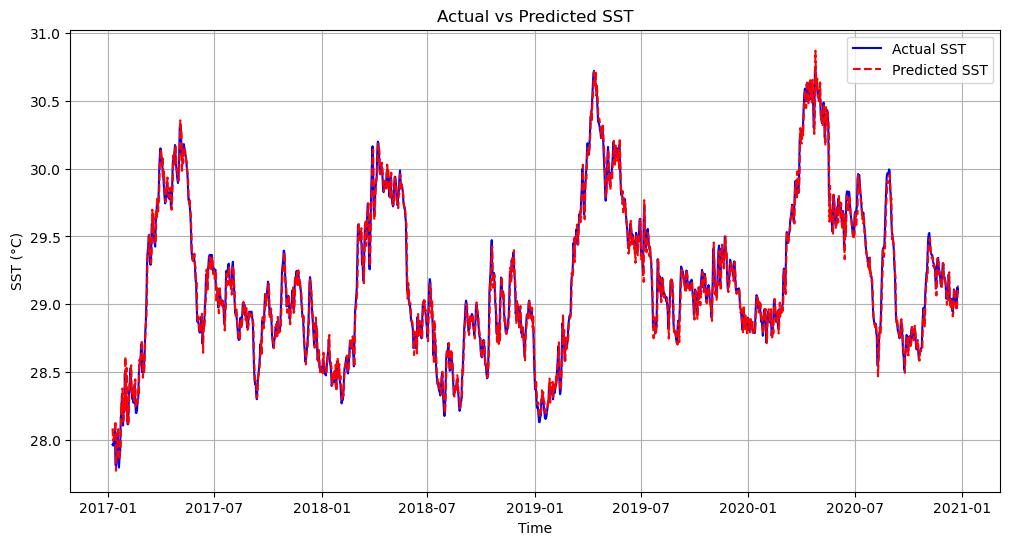

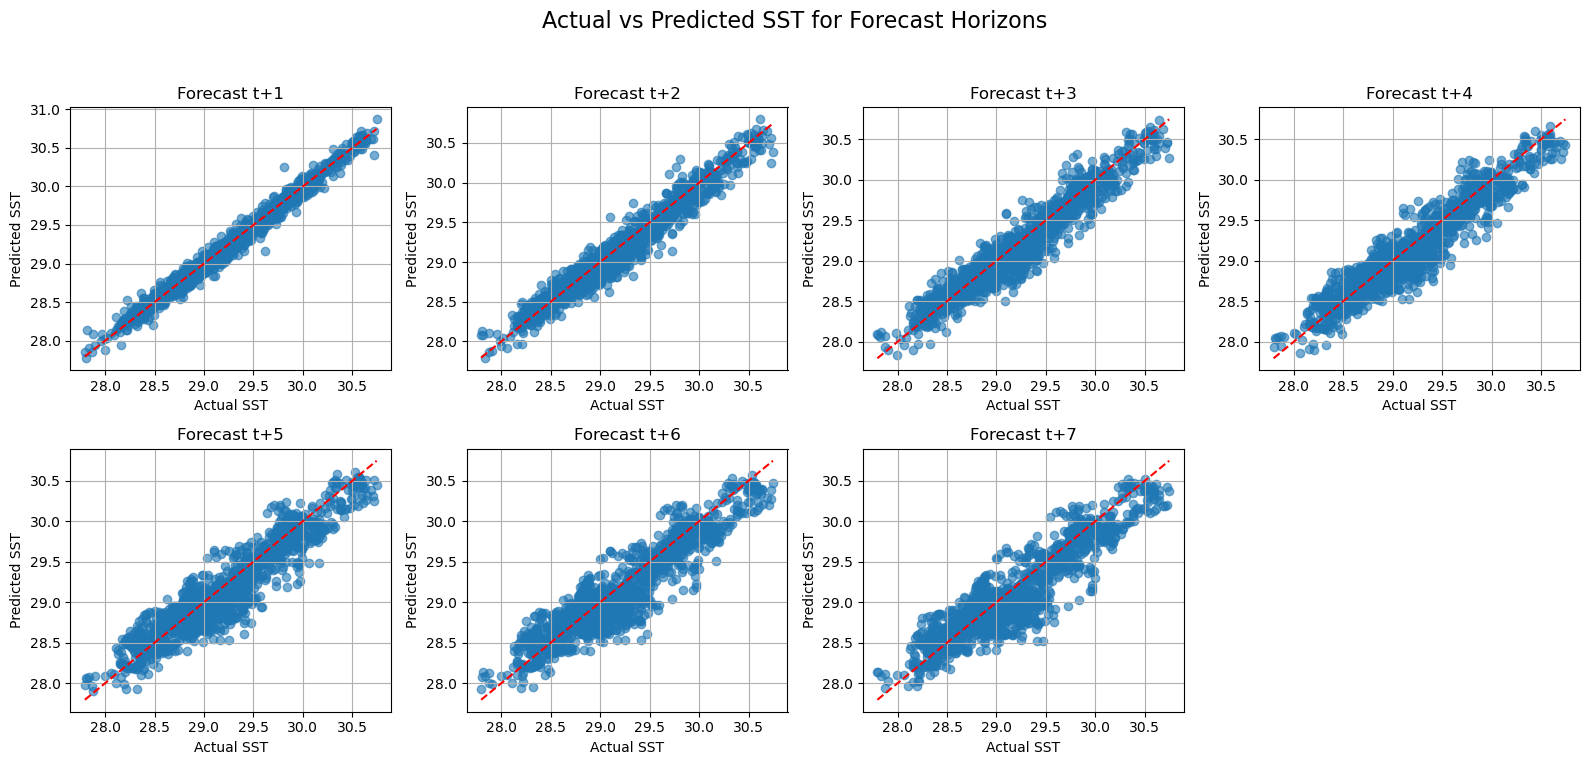

Forecast horizon t+1: RMSE = 0.0765, MAE = 0.0577, R2 = 0.9820
Forecast horizon t+2: RMSE = 0.1304, MAE = 0.0994, R2 = 0.9476
Forecast horizon t+3: RMSE = 0.1652, MAE = 0.1269, R2 = 0.9156
Forecast horizon t+4: RMSE = 0.1913, MAE = 0.1486, R2 = 0.8865
Forecast horizon t+5: RMSE = 0.2097, MAE = 0.1627, R2 = 0.8632
Forecast horizon t+6: RMSE = 0.2292, MAE = 0.1780, R2 = 0.8361
Forecast horizon t+7: RMSE = 0.2447, MAE = 0.1902, R2 = 0.8126


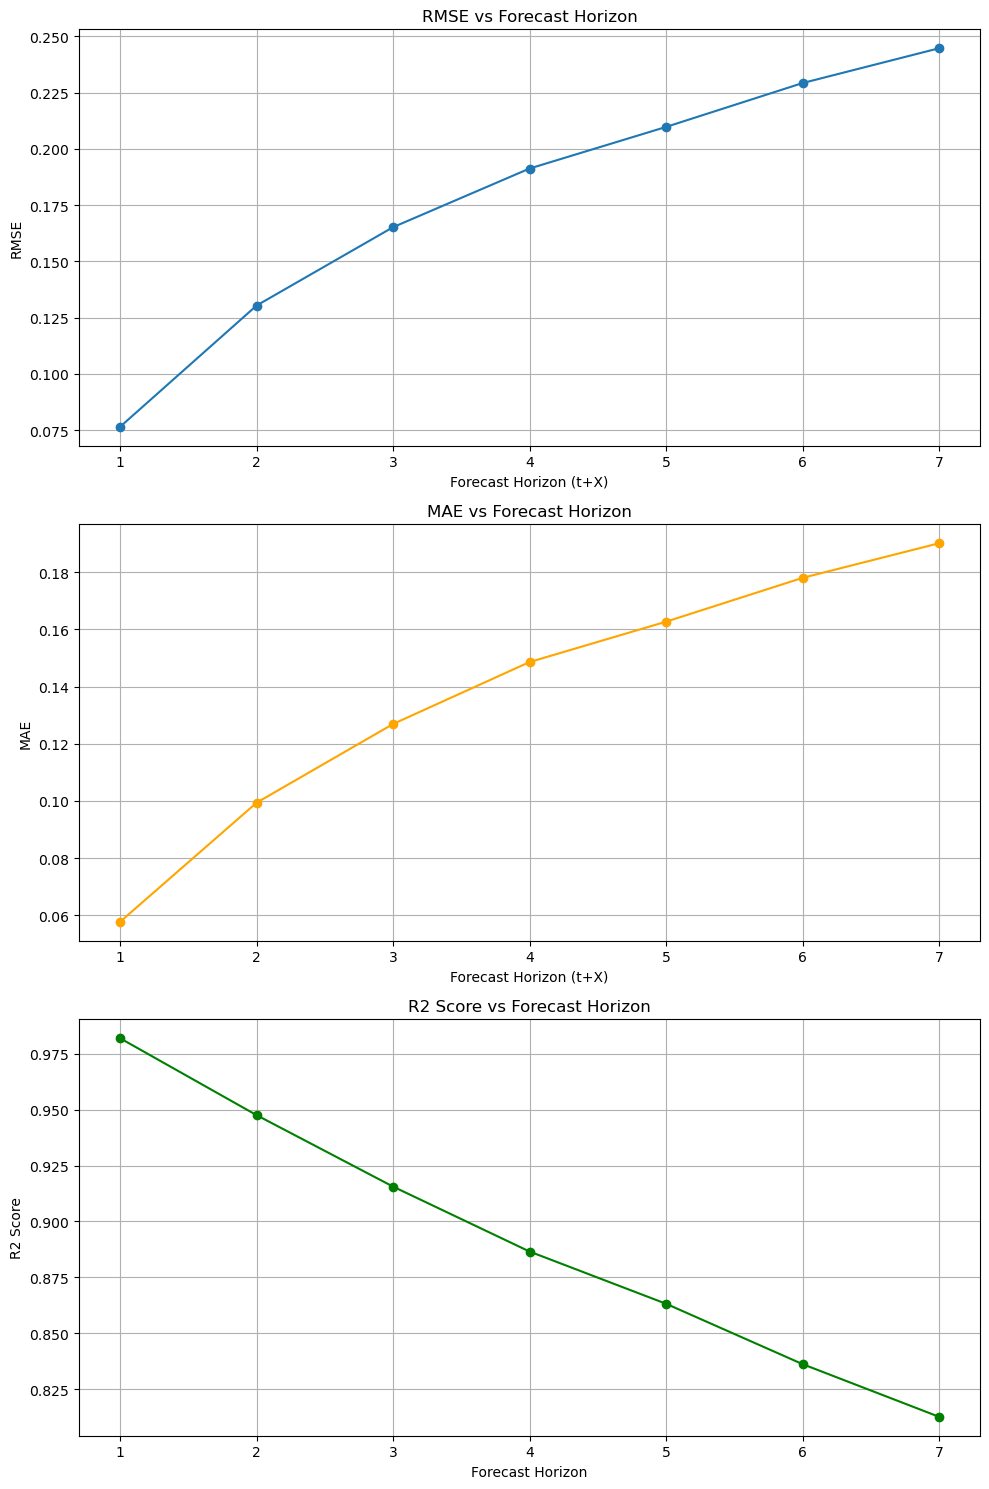

In [23]:
# Forecast and invert scaling
yhat_test_inverted, y_test_inverted = mhw_mb.forecast_and_invert(model, X_test, y_test, sst_min, sst_max)

# Extract predictions
actual_t1_test = y_test_inverted[:, 0]
predicted_t1_test = yhat_test_inverted[:, 0]
adjusted_test_time = test_time[n_lag : - (n_seq - 1)]

# Plot actual vs predicted for t forecast on the test set
mhw_mb.plot_actual_vs_predicted(
    adjusted_test_time, 
    actual_t1_test, 
    predicted_t1_test, 
    title="Actual vs Predicted SST"
)

mhw_mb.plot_sst_scatter_forecasts(y_test_inverted, yhat_test_inverted)
metrics_df_test = mhw_mb.plot_evaluation_metrics_all(y_test_inverted, yhat_test_inverted)
metrics_df_laccadive = metrics_df_test.copy()


#### MHW Prediciton Evaluation

In [24]:
train_ds_1, train_sst_1, train_t_1 = eda.load_and_prepare_data(file_path)
test_ds_1, test_sst_1, test_t_1 = eda.prepare_testing_dataset(file_path)


##### Plot for t+1 MHW predicted

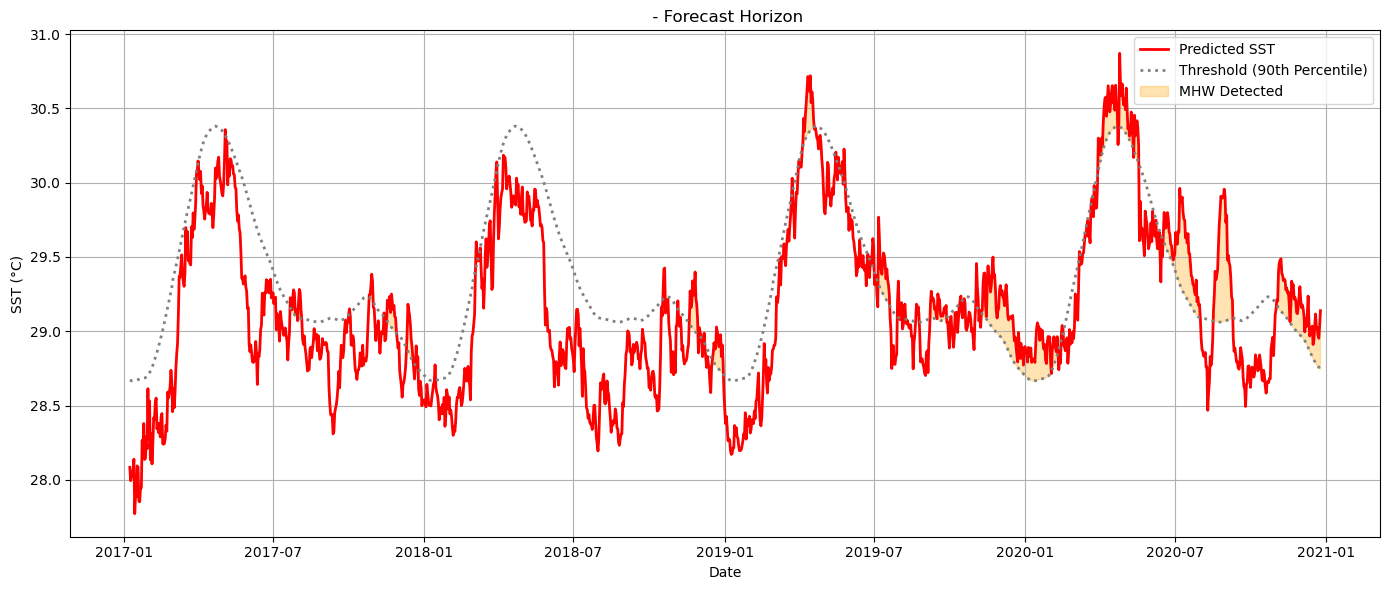

In [25]:
_, clim_pred = eda.detect_mhw_using_training_climatology(
    np.array([d.toordinal() for d in adjusted_test_time]),
    predicted_t1_test,
    train_t_1,
    train_sst_1
)

mhw_mb.plot_predicted_vs_climatology(
    time_array=adjusted_test_time,
    predicted_sst=predicted_t1_test,
    clim_ds=clim_pred)


Confusion Matrix for forecast horizon t+1:
[[1037    9]
 [  37  365]]


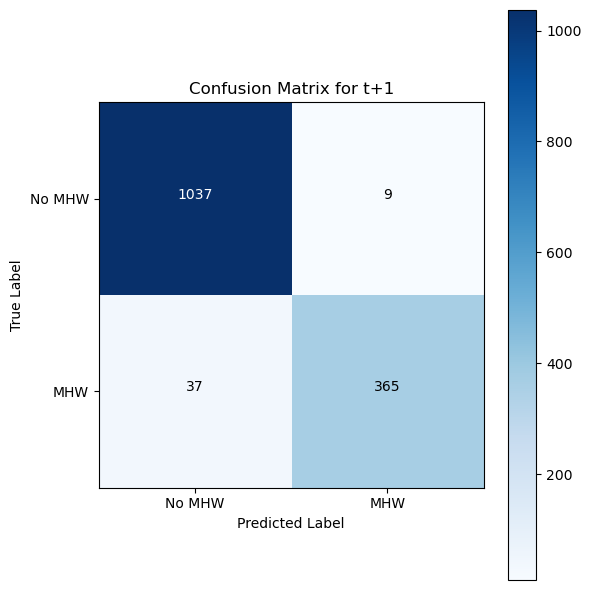

Confusion Matrix for forecast horizon t+2:
[[1028   17]
 [  74  329]]


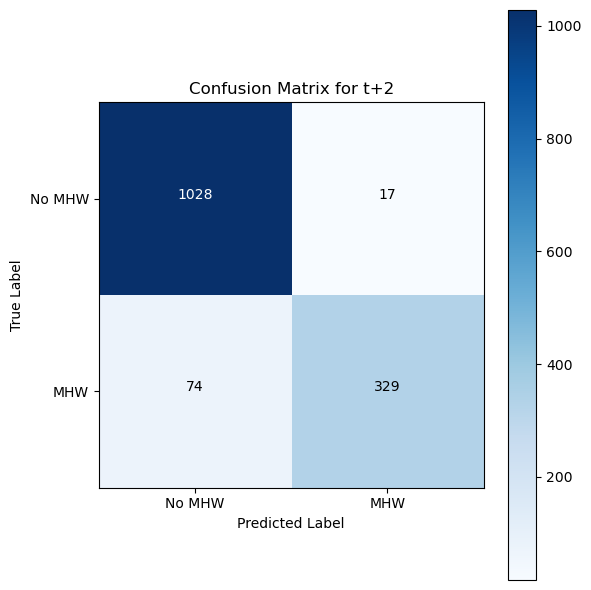

Confusion Matrix for forecast horizon t+3:
[[1016   28]
 [ 107  297]]


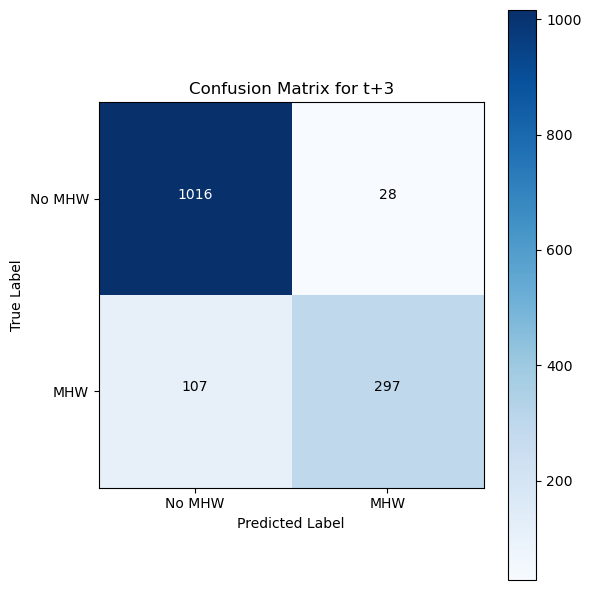

Confusion Matrix for forecast horizon t+4:
[[1008   35]
 [ 138  267]]


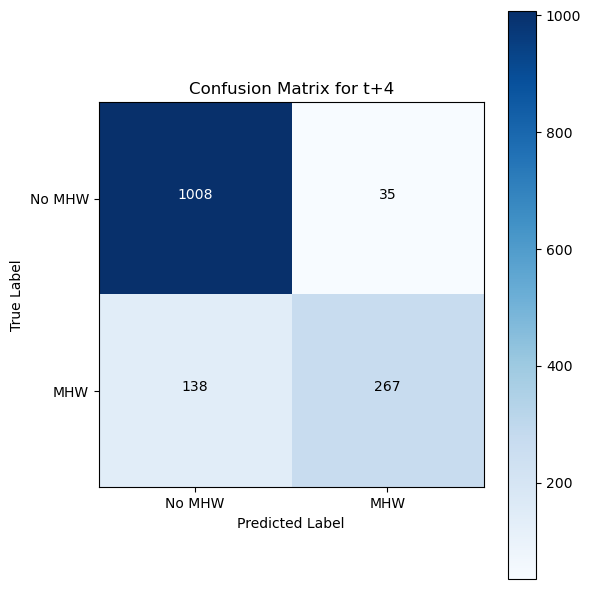

Confusion Matrix for forecast horizon t+5:
[[998  44]
 [164 242]]


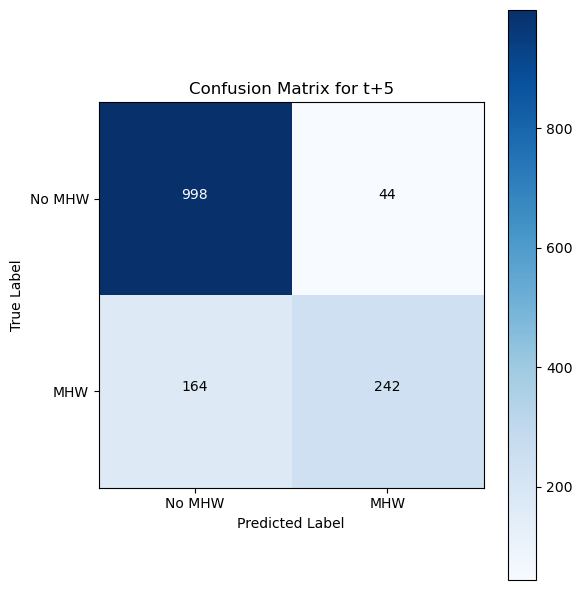

Confusion Matrix for forecast horizon t+6:
[[995  46]
 [189 218]]


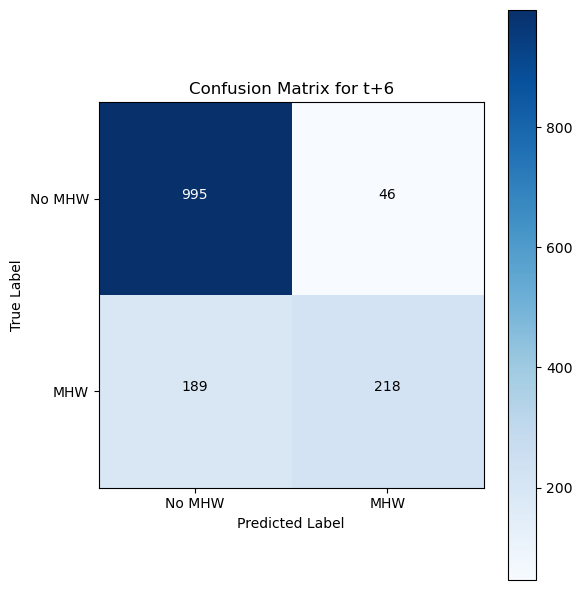

Confusion Matrix for forecast horizon t+7:
[[993  47]
 [211 197]]


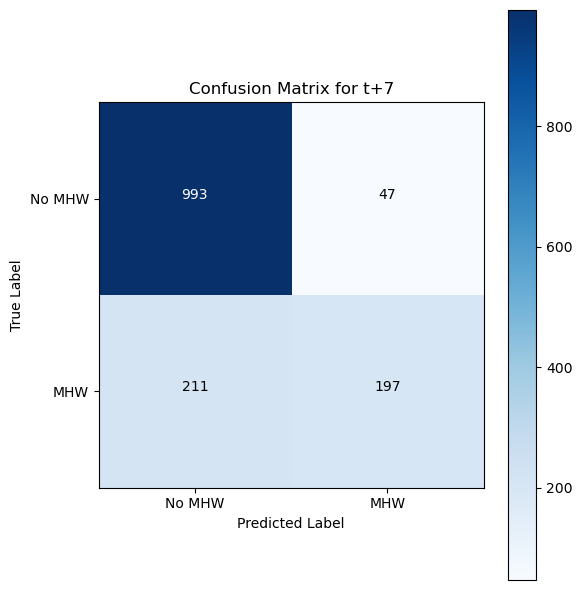

Precision  Recall (TPR)  F1 Score  Accuracy       FPR       TPR  \
Horizon                                                                    
t+1       0.975936      0.907960  0.940722  0.968232  0.008604  0.907960   
t+2       0.950867      0.816377  0.878505  0.937155  0.016268  0.816377   
t+3       0.913846      0.735149  0.814815  0.906768  0.026820  0.735149   
t+4       0.884106      0.659259  0.755304  0.880525  0.033557  0.659259   
t+5       0.846154      0.596059  0.699422  0.856354  0.042226  0.596059   
t+6       0.825758      0.535627  0.649776  0.837707  0.044188  0.535627   
t+7       0.807377      0.482843  0.604294  0.821823  0.045192  0.482843   

              FNR       FDR  
Horizon                      
t+1      0.092040  0.024064  
t+2      0.183623  0.049133  
t+3      0.264851  0.086154  
t+4      0.340741  0.115894  
t+5      0.403941  0.153846  
t+6      0.464373  0.174242  
t+7      0.517157  0.192623

In [26]:
metrics_all = mhw_mb.evaluate_mhw_forecast_horizons(
    adjusted_test_time, y_test_inverted, yhat_test_inverted, train_t_1, train_sst_1, eda
)

df_metrics = mhw_mb.metrics_to_dataframe(metrics_all)
metrics_df_laccadive_mhw = df_metrics.copy()
df_metrics

### Sri Lankan Coast

##### Model Training 

(10944, 7, 2)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                17152     
                                                                 
 dense_4 (Dense)             (None, 7)                 455       
                                                                 
Total params: 17,607
Trainable params: 17,607
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
86/86 [==============================] - 4s 16ms/step - loss: 0.1314 - val_loss: 0.0531
Epoch 2/200
86/86 [==============================] - 1s 11ms/step - loss: 0.0629 - val_loss: 0.0508
Epoch 3/200
86/86 [==============================] - 1s 10ms/step - loss: 0.0615 - val_loss: 0.0490
Epoch 4/200
86/86 [==============================] - 1s 8ms/step - loss: 0.0609 - val_loss: 0.0484
Epoch 5/200
86/86 [==============

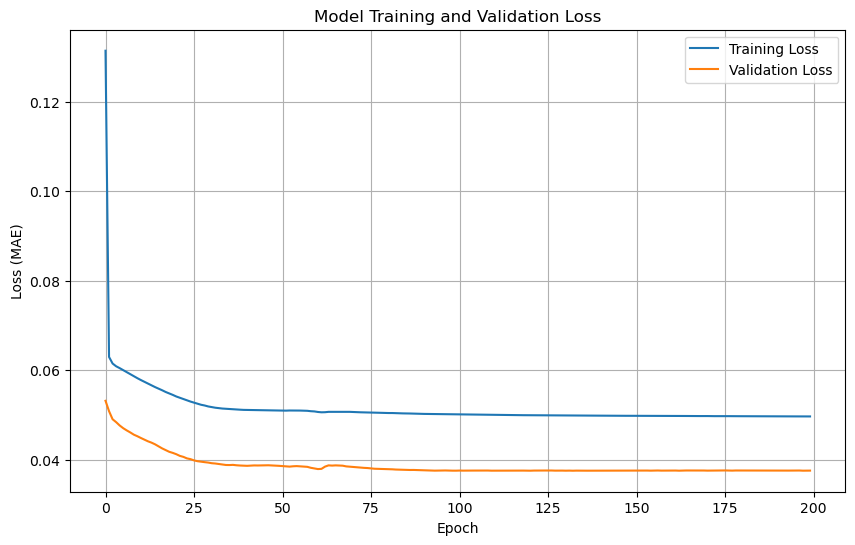

In [27]:
file_path = "Data_sst_2020/sri_lankan_coast.nc"
dataset = mhw_mb.load_data(file_path)

# Data splitting 
(train_sst, train_month, train_time), (valid_sst, valid_month, valid_time), (test_sst, test_month, test_time) = mhw_mb.prepare_data_for_modeling(dataset)

# Scale and convert to supervised format
X_train, y_train, X_valid, y_valid, X_test, y_test, sst_min, sst_max = mhw_mb.scale_and_create_sequences(
    train_sst, train_month, valid_sst, valid_month, test_sst, test_month, n_lag, n_seq
)
print(X_train.shape)

model = mhw_mb.build_lstm_model(n_lag, n_features, n_seq)
model.summary()

# Fit Model
history = mhw_mb.fit_lstm_model(model, X_train, y_train, X_valid, y_valid, epochs=epochs, batch_size=batch_size)

mhw_mb.plot_training_history(history)


##### Model Testing and Evaluation

46/46 [==============================] - 1s 3ms/step


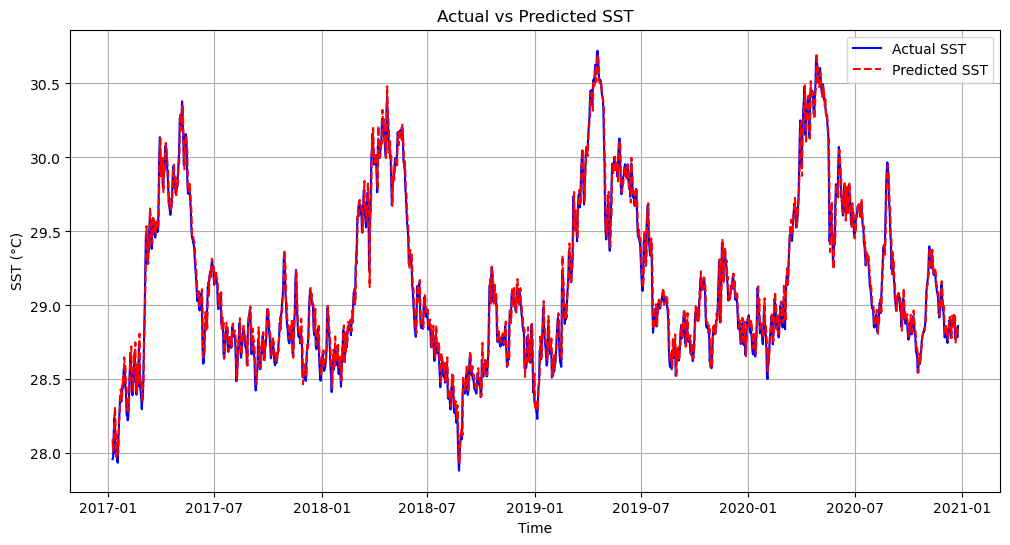

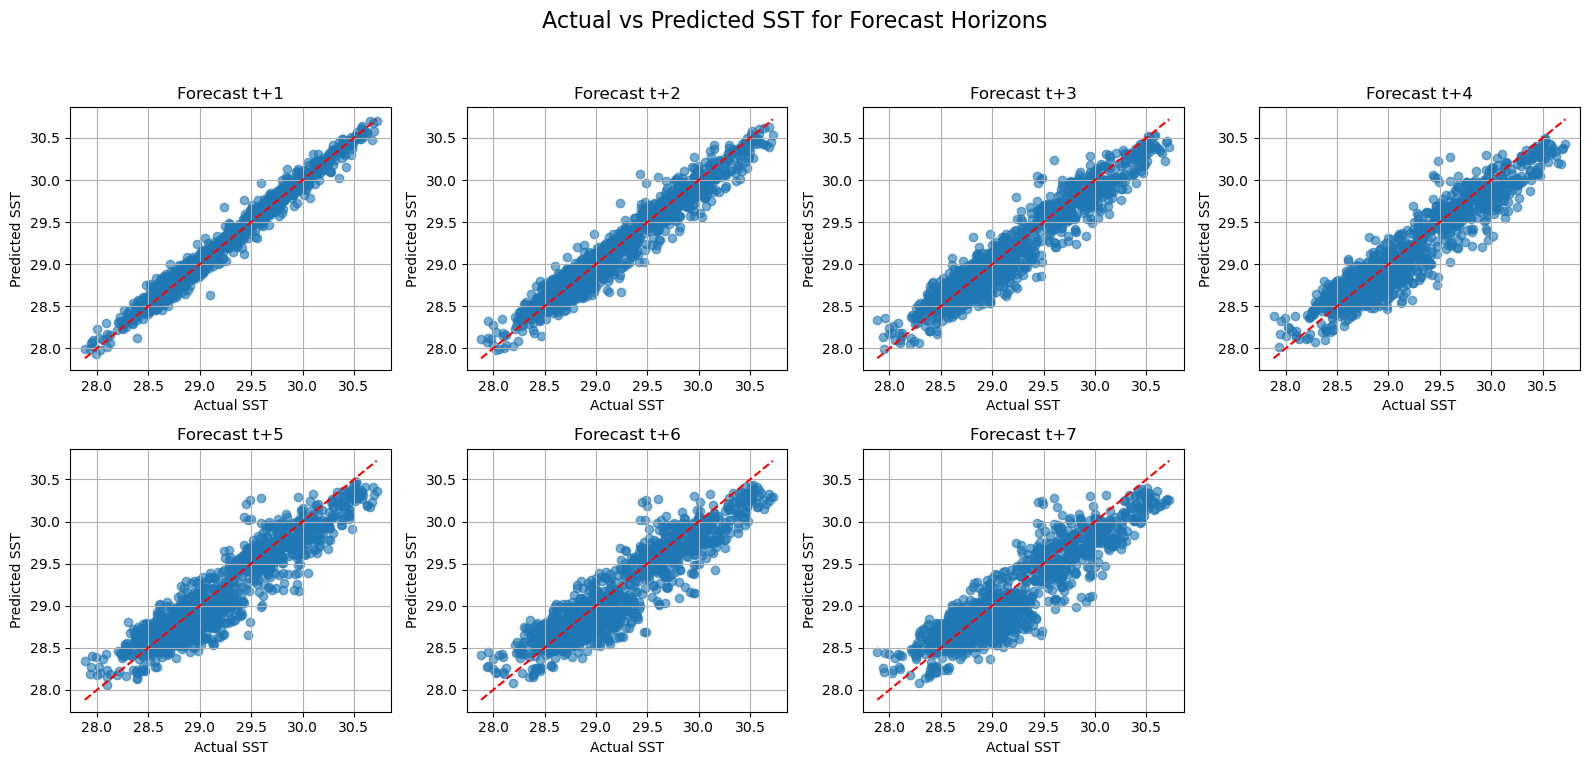

Forecast horizon t+1: RMSE = 0.0825, MAE = 0.0625, R2 = 0.9789
Forecast horizon t+2: RMSE = 0.1340, MAE = 0.1024, R2 = 0.9441
Forecast horizon t+3: RMSE = 0.1696, MAE = 0.1312, R2 = 0.9101
Forecast horizon t+4: RMSE = 0.1934, MAE = 0.1497, R2 = 0.8830
Forecast horizon t+5: RMSE = 0.2097, MAE = 0.1628, R2 = 0.8621
Forecast horizon t+6: RMSE = 0.2219, MAE = 0.1732, R2 = 0.8454
Forecast horizon t+7: RMSE = 0.2382, MAE = 0.1862, R2 = 0.8214


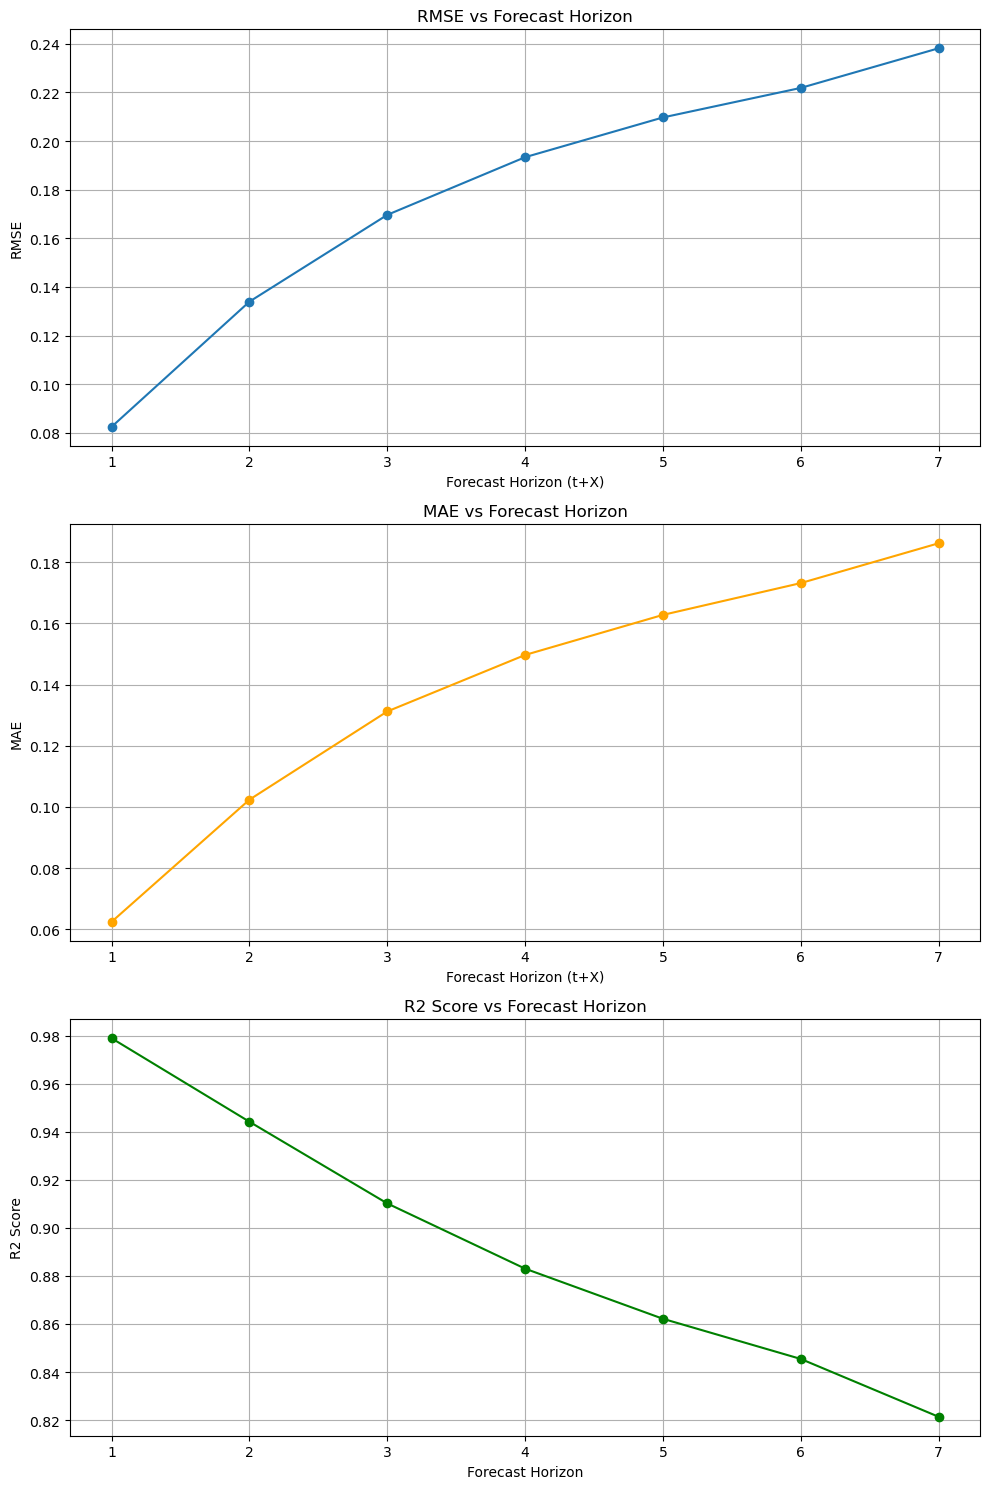

In [28]:
# Forecast and invert scaling
yhat_test_inverted, y_test_inverted = mhw_mb.forecast_and_invert(model, X_test, y_test, sst_min, sst_max)

# Extract predictions t+1
actual_t1_test = y_test_inverted[:, 0]
predicted_t1_test = yhat_test_inverted[:, 0]
adjusted_test_time = test_time[n_lag : - (n_seq - 1)]

# Plot actual vs predicted for t forecast on the test set
mhw_mb.plot_actual_vs_predicted(
    adjusted_test_time, 
    actual_t1_test, 
    predicted_t1_test, 
    title="Actual vs Predicted SST"
)

mhw_mb.plot_sst_scatter_forecasts(y_test_inverted, yhat_test_inverted)
metrics_df_test = mhw_mb.plot_evaluation_metrics_all(y_test_inverted, yhat_test_inverted)
metrics_df_sl = metrics_df_test.copy()


#### MHW Prediciton Evaluation

In [29]:
train_ds_1, train_sst_1, train_t_1 = eda.load_and_prepare_data(file_path)
test_ds_1, test_sst_1, test_t_1 = eda.prepare_testing_dataset(file_path)


##### Plot for t+1 MHW predicted

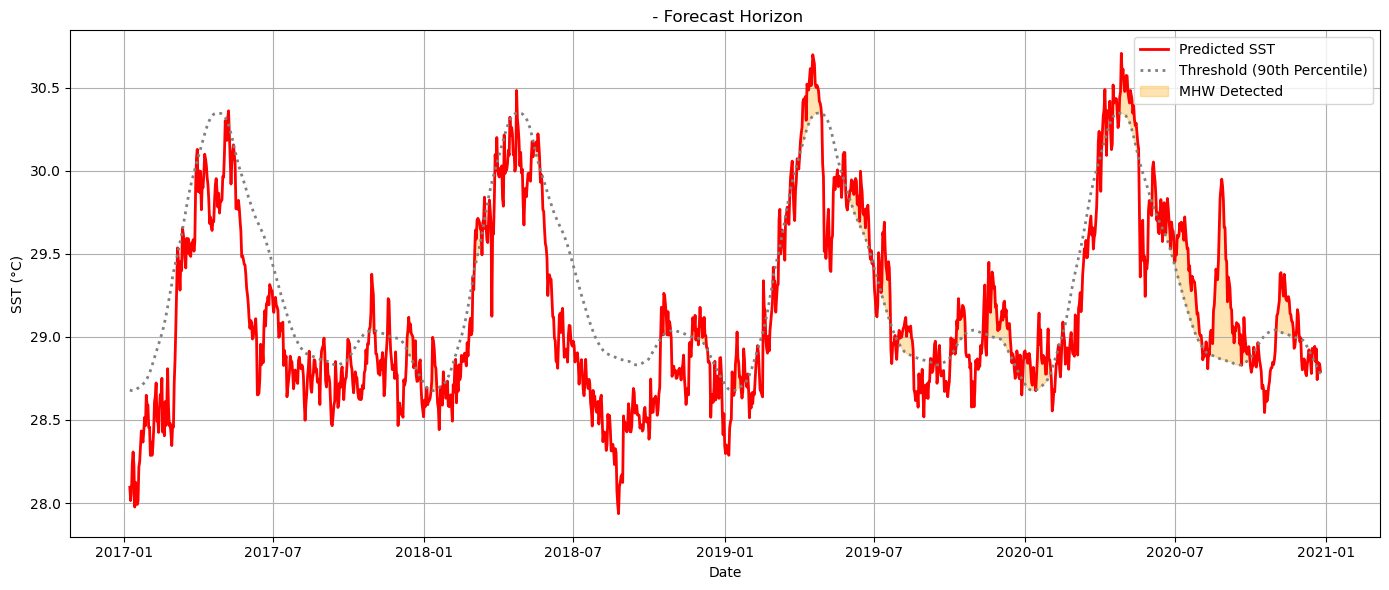

In [30]:
_, clim_pred = eda.detect_mhw_using_training_climatology(
    np.array([d.toordinal() for d in adjusted_test_time]),
    predicted_t1_test,
    train_t_1,
    train_sst_1
)

mhw_mb.plot_predicted_vs_climatology(
    time_array=adjusted_test_time,
    predicted_sst=predicted_t1_test,
    clim_ds=clim_pred
)


Confusion Matrix for forecast horizon t+1:
[[1004   35]
 [  39  370]]


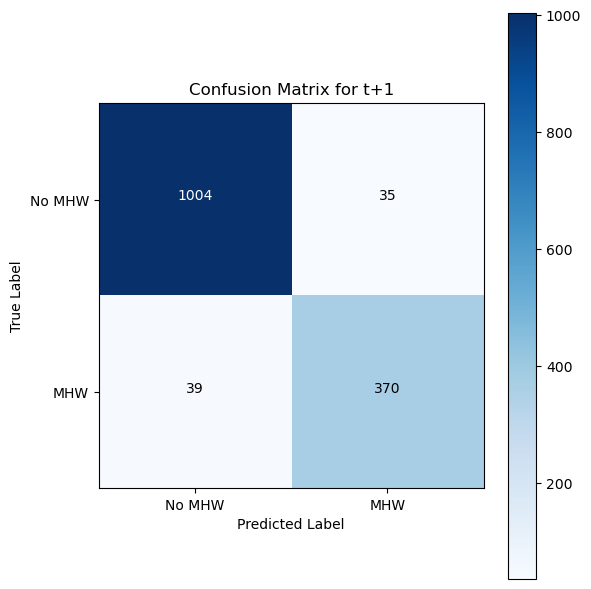

Confusion Matrix for forecast horizon t+2:
[[1009   30]
 [ 114  295]]


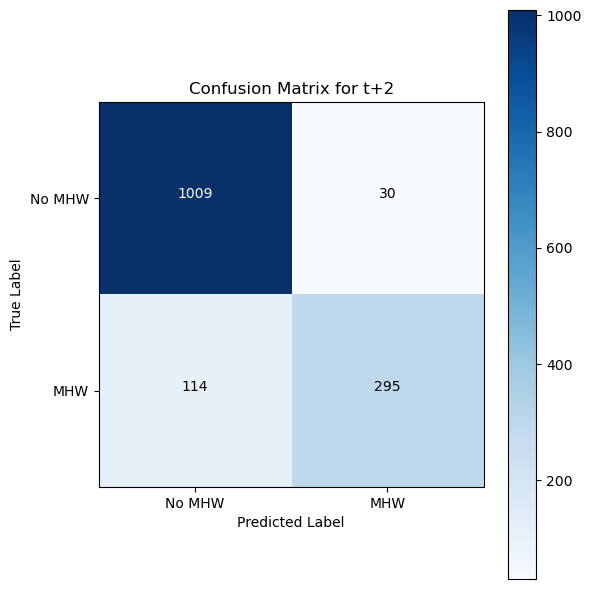

Confusion Matrix for forecast horizon t+3:
[[1007   32]
 [ 169  240]]


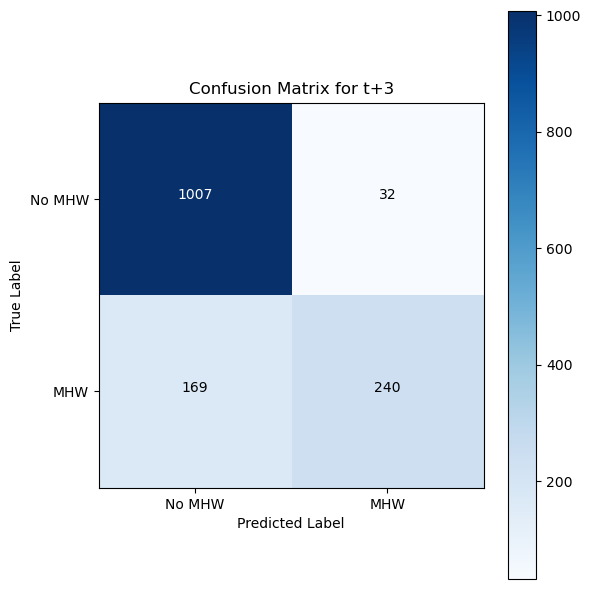

Confusion Matrix for forecast horizon t+4:
[[1009   30]
 [ 221  188]]


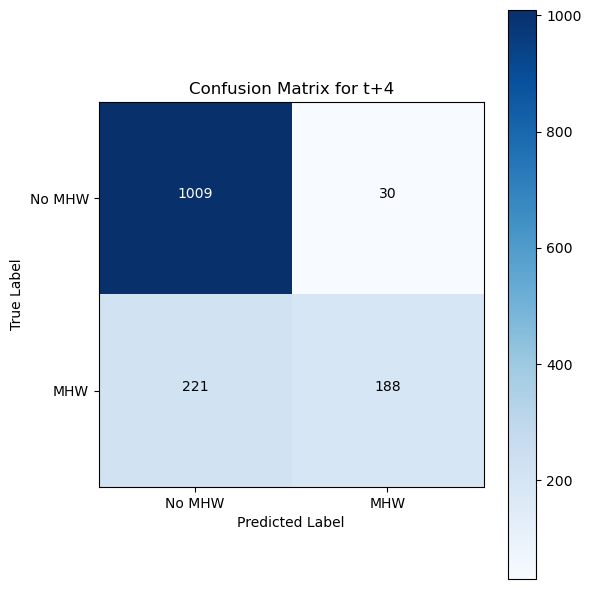

Confusion Matrix for forecast horizon t+5:
[[1002   32]
 [ 264  150]]


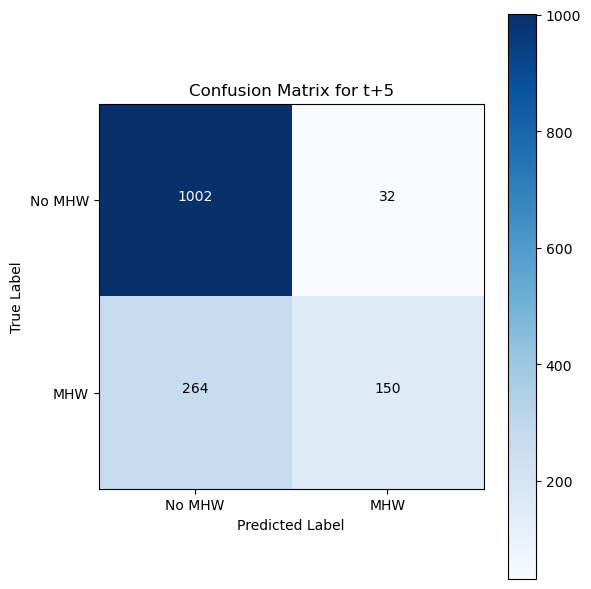

Confusion Matrix for forecast horizon t+6:
[[995  38]
 [288 127]]


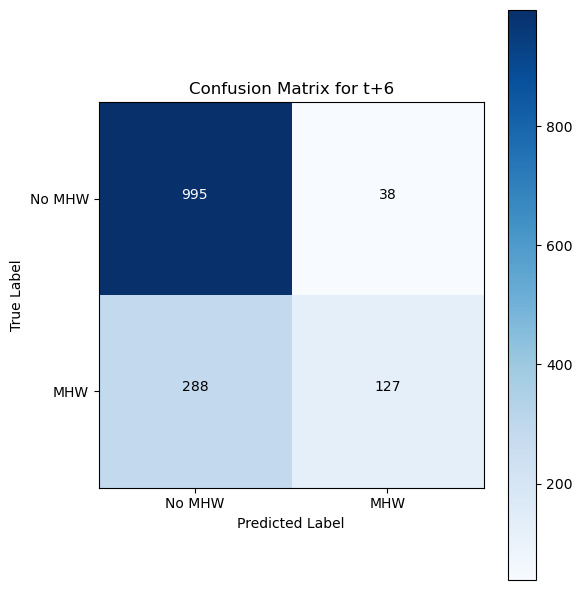

Confusion Matrix for forecast horizon t+7:
[[996  36]
 [334  82]]


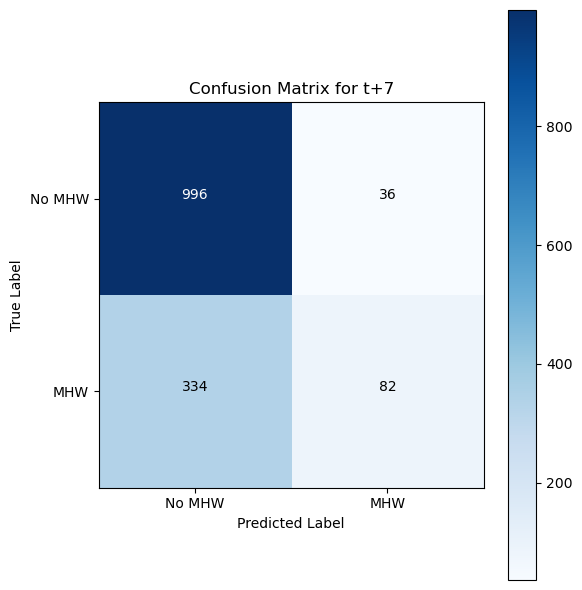

Precision  Recall (TPR)  F1 Score  Accuracy       FPR       TPR  \
Horizon                                                                    
t+1       0.913580      0.904645  0.909091  0.948895  0.033686  0.904645   
t+2       0.907692      0.721271  0.803815  0.900552  0.028874  0.721271   
t+3       0.882353      0.586797  0.704846  0.861188  0.030799  0.586797   
t+4       0.862385      0.459658  0.599681  0.826657  0.028874  0.459658   
t+5       0.824176      0.362319  0.503356  0.795580  0.030948  0.362319   
t+6       0.769697      0.306024  0.437931  0.774862  0.036786  0.306024   
t+7       0.694915      0.197115  0.307116  0.744475  0.034884  0.197115   

              FNR       FDR  
Horizon                      
t+1      0.095355  0.086420  
t+2      0.278729  0.092308  
t+3      0.413203  0.117647  
t+4      0.540342  0.137615  
t+5      0.637681  0.175824  
t+6      0.693976  0.230303  
t+7      0.802885  0.305085

In [31]:
metrics_all = mhw_mb.evaluate_mhw_forecast_horizons(
    adjusted_test_time, y_test_inverted, yhat_test_inverted, train_t_1, train_sst_1, eda
)

df_metrics = mhw_mb.metrics_to_dataframe(metrics_all)
metrics_df_sl_mhw = df_metrics.copy()
df_metrics

### Comparative Analysis

In [33]:
rmse_results = {
    "Bay of Bengal": metrics_df_bay["RMSE"].values,
    "Gulf of Mannar": metrics_df_mannar["RMSE"].values,
    "Laccadive Sea": metrics_df_laccadive["RMSE"].values,
    "Sri Lankan Coast": metrics_df_sl["RMSE"].values
}

In [34]:
f1_results = {
    "Bay of Bengal": metrics_df_bay_mhw["F1 Score"].values,
    "Gulf of Mannar": metrics_df_mannar_mhw["F1 Score"].values,
    "Laccadive Sea": metrics_df_laccadive_mhw["F1 Score"].values,
    "Sri Lankan Coast": metrics_df_sl_mhw["F1 Score"].values
}

#### RMSE Plot Across all forecast horizons and Regions

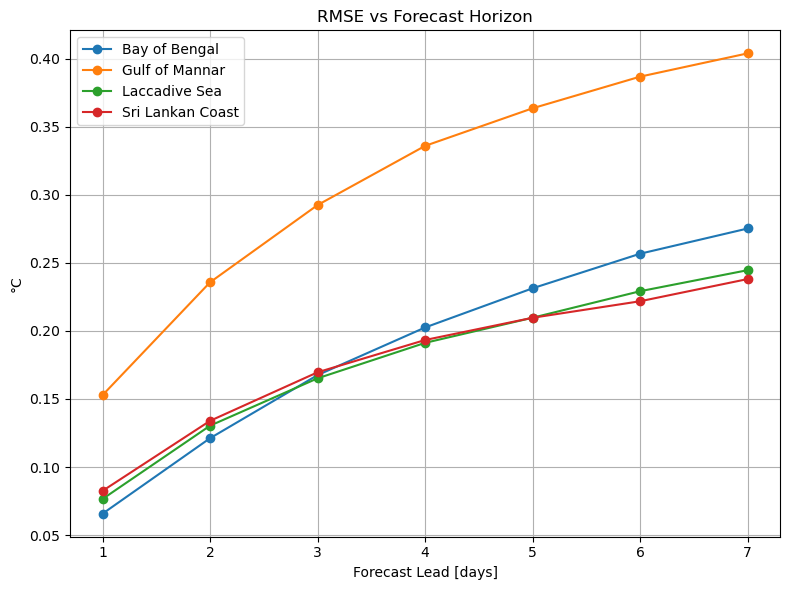

In [35]:
mhw_mb.plot_metric_by_region(rmse_results, metric_name="RMSE", ylabel="°C")


#### F1-Score Plot Across all forecast horizons and Regions

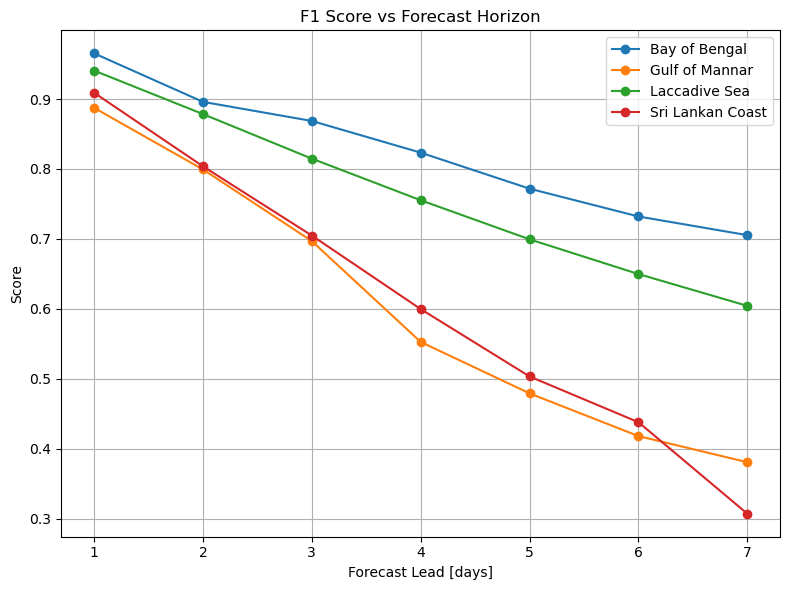

In [36]:
mhw_mb.plot_metric_by_region(f1_results, metric_name="F1 Score", ylabel="Score")


In [37]:
# Extract metric arrays for each region and metric
tpr_results = {
    "Bay of Bengal": metrics_df_bay_mhw["TPR"].values,
    "Gulf of Mannar": metrics_df_mannar_mhw["TPR"].values,
    "Laccadive Sea": metrics_df_laccadive_mhw["TPR"].values,
    "Sri Lankan Coast": metrics_df_sl_mhw["TPR"].values
}

tnr_results = {
    "Bay of Bengal": 1 - metrics_df_bay_mhw["FPR"].values,  # TNR = 1 - FPR
    "Gulf of Mannar": 1 - metrics_df_mannar_mhw["FPR"].values,
    "Laccadive Sea": 1 - metrics_df_laccadive_mhw["FPR"].values,
    "Sri Lankan Coast": 1 - metrics_df_sl_mhw["FPR"].values
}

fpr_results = {
    "Bay of Bengal": metrics_df_bay_mhw["FPR"].values,
    "Gulf of Mannar": metrics_df_mannar_mhw["FPR"].values,
    "Laccadive Sea": metrics_df_laccadive_mhw["FPR"].values,
    "Sri Lankan Coast": metrics_df_sl_mhw["FPR"].values
}

fnr_results = {
    "Bay of Bengal": metrics_df_bay_mhw["FNR"].values,
    "Gulf of Mannar": metrics_df_mannar_mhw["FNR"].values,
    "Laccadive Sea": metrics_df_laccadive_mhw["FNR"].values,
    "Sri Lankan Coast": metrics_df_sl_mhw["FNR"].values
}


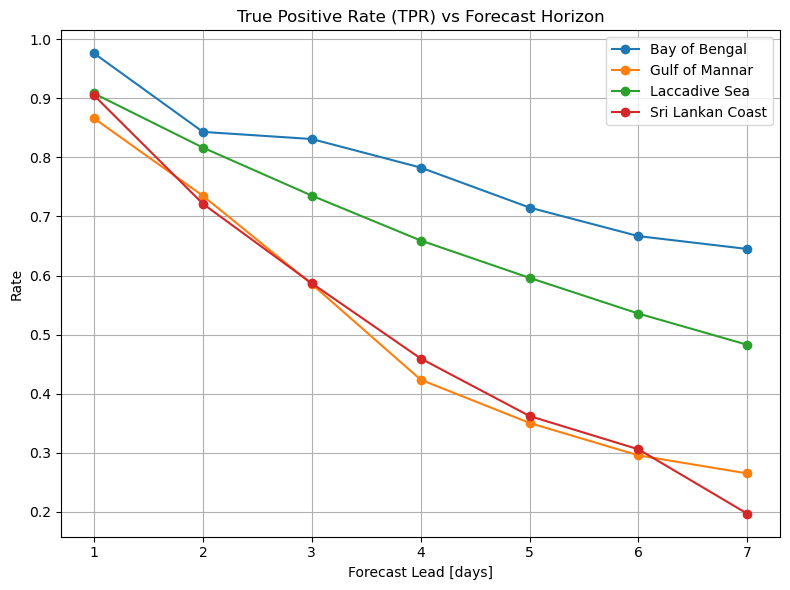

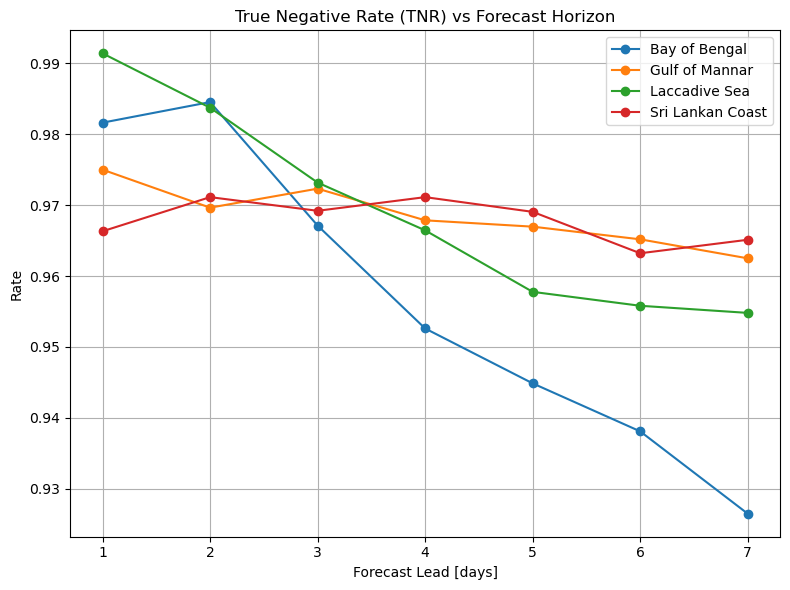

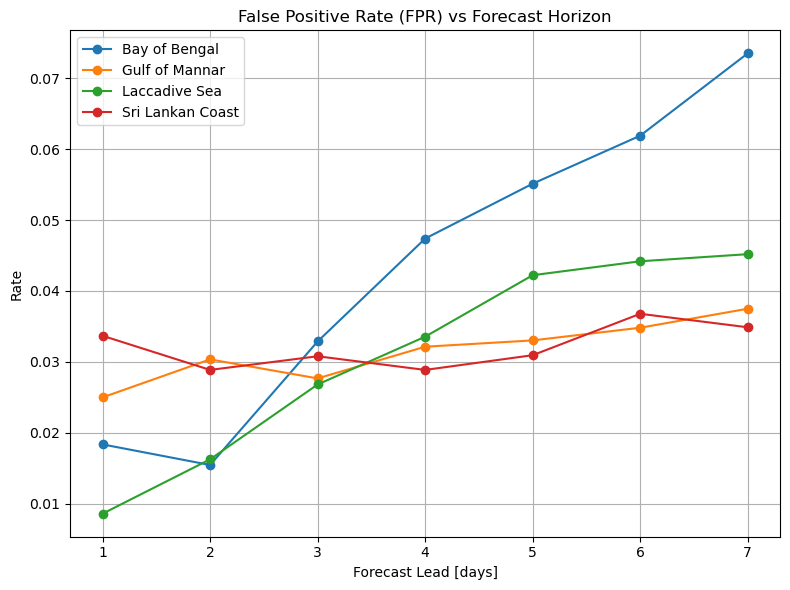

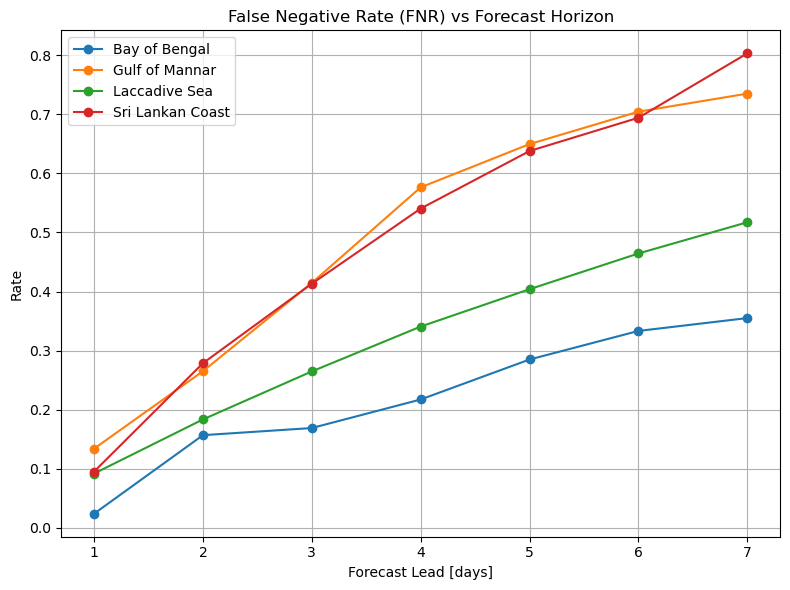

In [38]:
mhw_mb.plot_metric_by_region(tpr_results, metric_name="True Positive Rate (TPR)", ylabel="Rate")
mhw_mb.plot_metric_by_region(tnr_results, metric_name="True Negative Rate (TNR)", ylabel="Rate")
mhw_mb.plot_metric_by_region(fpr_results, metric_name="False Positive Rate (FPR)", ylabel="Rate")
mhw_mb.plot_metric_by_region(fnr_results, metric_name="False Negative Rate (FNR)", ylabel="Rate")
